# 생체인증보안 1871085 지문 2차 코드

In [1]:
# 라이브러리 import
import PIL.Image as pilimg
import numpy as np
import glob
import matplotlib.pyplot as plt
import re

In [2]:
# 이미지 목록
images = glob.glob('./01_finger_training/*.bmp')
len(images)

80

In [3]:
r = re.compile('\d+')

img = [] # 이미지
label = [] # 라벨

for fname in images:
    l = r.findall(fname)[1]
    if l == '8': # 처리 편의성을 위해 라벨 범위를 1-8에서 0-7로 변경
        l = '0'
    label.append(l)
    im = pilimg.open(fname)
    pix = np.array(im)[25:120,25:120]/255. # 검은 부분 제거, Normalize
    img.append(pix)

In [4]:
X = np.array(img)
X = X.reshape(X.shape[0],95,95,1)
X.shape # img shape

(80, 95, 95, 1)

In [5]:
y = np.array(label, dtype='int32')
y # label

array([7, 4, 6, 4, 6, 3, 7, 1, 7, 3, 3, 0, 1, 4, 4, 7, 6, 7, 1, 6, 5, 4,
       1, 1, 2, 1, 5, 3, 0, 4, 6, 4, 5, 5, 2, 3, 7, 1, 2, 3, 2, 1, 5, 3,
       7, 2, 6, 0, 4, 5, 0, 3, 1, 0, 0, 3, 6, 0, 5, 6, 5, 2, 4, 0, 0, 2,
       2, 0, 6, 3, 7, 1, 7, 5, 5, 2, 4, 2, 7, 6], dtype=int32)

(95, 95, 1)
7


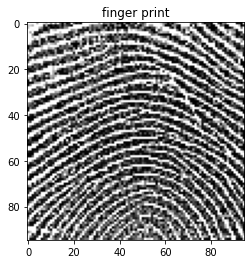

In [6]:
# 지문 이미지
plt.title('finger print')
plt.imshow(X[0], cmap='gray')
print(X[0].shape)
print(y[0])

In [7]:
X.shape

(80, 95, 95, 1)

## PCA로 데이터 분포 확인

In [8]:
from sklearn.decomposition import PCA
X_ = X.reshape(80,9025)
pca_X = PCA(2)
X_data_proj = pca_X.fit_transform(X_)

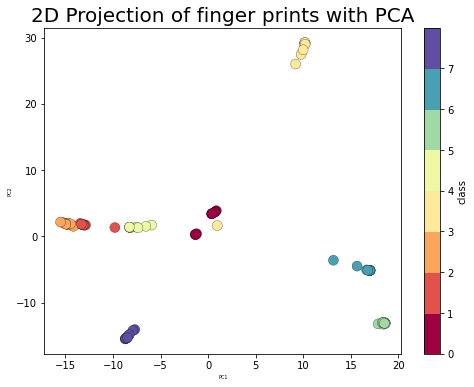

In [9]:
plt.figure(num='', figsize=(8,6))
plt.scatter(X_data_proj[:,0], X_data_proj[:,1], lw=0.25, c=y, edgecolor='k', s=100,
           cmap=plt.cm.get_cmap('Spectral',8))
plt.xlabel('PC1', size=5)
plt.ylabel('PC2', size=5)
plt.title('2D Projection of finger prints with PCA', size=20)
plt.colorbar(ticks=range(8), label='class')
plt.clim(0, 8)
plt.show()

## Data Augmentation

In [10]:
# !pip install imgaug

In [11]:
from imgaug import augmenters as iaa

In [12]:
seq = iaa.Sequential([
    # blur images with a sigma of 0 to 0.1
    iaa.GaussianBlur(sigma=(0, 0.1)),
    iaa.Affine(
        # scale images to 90-110% of their size, individually per axis
        #scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # translate by -10 to +10 percent (per axis)
        translate_percent={"x": (-0.01, 0.01), "y": (-0.01, 0.01)},
        # rotate by -5 to +5 degrees
        #rotate=(-5, 5),
        # use nearest neighbour or bilinear interpolation (fast)
        order=[0, 1],
        # if mode is constant, use a cval between 0 and 255
        cval=0
    )
], random_order=True)

def aug_data(X_data, y_data):
    augmentated_data = [] # 생성한 이미지
    augmentated_label = [] # 생성한 이미지의 라벨
    for i in range(len(X)):
        augs = [X[i]] * 9 # 이미지당 9개 추가 생성
        augs = seq.augment_images(augs)
        for aug in augs:
            augmentated_data.append(aug)
            augmentated_label.append(y_data[i])
    
    return augmentated_data, augmentated_label

In [13]:
x_d, y_d = aug_data(X, y) # 이미지 생성

In [14]:
print(len(x_d), len(y_d))

720 720


(95, 95, 1)
7


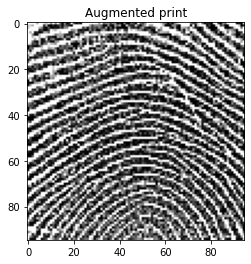

In [15]:
# 생성한 지문 이미지
plt.title('Augmented print')
plt.imshow(x_d[0], cmap='gray')
print(x_d[0].shape)
print(y_d[0])

In [16]:
# 생성한 이미지
x_d = np.array(x_d)
y_d = np.array(y_d)
print(x_d.shape)
print(y_d.shape)

(720, 95, 95, 1)
(720,)


In [17]:
# 기존 이미지
print(X.shape)
print(y.shape)

(80, 95, 95, 1)
(80,)


In [18]:
# 기존 이미지, 생성 이미지 합치기
X_data = np.concatenate([X, x_d], axis=0)
y_data = np.concatenate([y, y_d], axis=0)
print(X_data.shape)
print(y_data.shape)

(800, 95, 95, 1)
(800,)


# Augmentation 후 데이터 분포 확인

In [19]:
from sklearn.decomposition import PCA
X_d_ = X_data.reshape(800,9025)
pca_X = PCA(2)
X_d_proj = pca_X.fit_transform(X_d_)

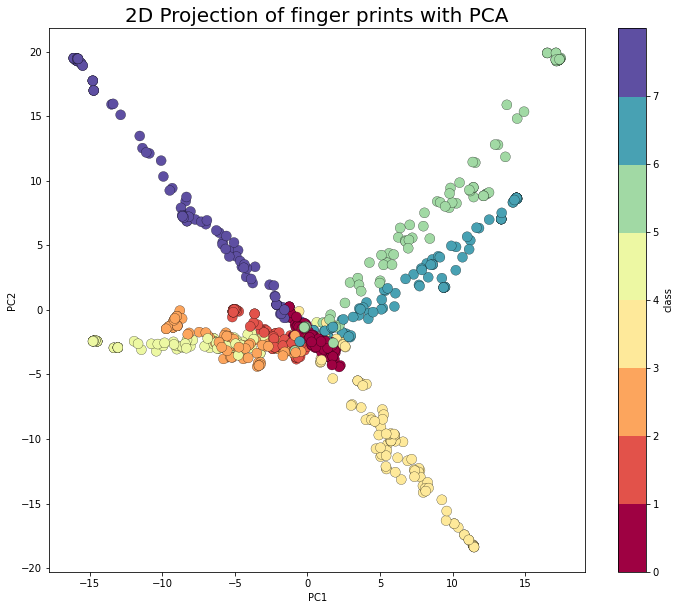

In [20]:
plt.figure(num='', figsize=(12,10))
plt.scatter(X_d_proj[:,0], X_d_proj[:,1], lw=0.25, c=y_data, edgecolor='k', s=100,
           cmap=plt.cm.get_cmap('Spectral',8))
plt.xlabel('PC1', size=10)
plt.ylabel('PC2', size=10)
plt.title('2D Projection of finger prints with PCA', size=20)
plt.colorbar(ticks=range(8), label='class')
plt.clim(0, 8)
plt.show()

# Data split

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data, test_size=0.2, shuffle=True, stratify=y_data, random_state=101)

In [22]:
X_train=X_train.astype('float32')
y_train=y_train.astype('int32')
X_test=X_test.astype('float32')
y_test=y_test.astype('int32')

In [23]:
X_train = X_train.reshape(X_train.shape[0],95,95,1)
X_test = X_test.reshape(X_test.shape[0],95,95,1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(640, 95, 95, 1) (640,) (160, 95, 95, 1) (160,)


In [24]:
# Input shape
X_train[0].shape

(95, 95, 1)

# Model

In [25]:
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error

In [26]:
# shape 변환
X_train_2dim = X_train.reshape(X_train.shape[0], 9025)
X_test_2dim = X_test.reshape(X_test.shape[0], 9025)

In [27]:
print(X_test_2dim.shape)
print(X_test_2dim)

(160, 9025)
[[1.         1.         1.         ... 0.7137255  0.65882355 0.5882353 ]
 [0.91764706 0.5411765  1.         ... 0.22352941 0.22352941 1.        ]
 [0.3175743  0.26596966 0.596852   ... 1.         1.         0.71875   ]
 ...
 [0.01309743 0.04379595 0.06210937 ... 0.99482995 0.9941406  1.        ]
 [0.03143382 0.04191177 0.15110295 ... 0.5641544  0.85900736 0.9007353 ]
 [0.         0.         0.         ... 0.17254902 0.17254902 0.17254902]]


In [28]:
model = xgb.XGBClassifier(learning_rate = 0.001, max_depth = 6, n_estimators = 2000)

In [29]:
# Cross validation
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
all_history = [] # 결과 저장

def score_model(model, cv=None):
    if cv is None:
        cv = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)
        
    i=0
    for train_fold_index, val_fold_index in cv.split(X_train_2dim, y_train):
        i=i+1
        print('Fold #',i)
        # Get the training data
        X_train_fold, y_train_fold = X_train[train_fold_index], y_train[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_train[val_fold_index], y_train[val_fold_index]
        
        x,y,z,w = X_train_fold.shape
        print(y_val_fold)
        X_train_reshaped = X_train_fold.reshape(X_train_fold.shape[0], 9025)
        X_val_reshaped = X_val_fold.reshape(X_val_fold.shape[0], 9025)
        
        print(X_val_reshaped.shape)
        print(y_val_fold.shape)
        
        # Fit the model
        evals = [(X_train_reshaped, y_train_fold), (X_val_reshaped, y_val_fold)]
        model_obj = model.fit(X_train_reshaped, y_train_fold,
                              eval_metric=["mlogloss"], 
                              eval_set=evals, 
                              verbose=1)
        all_history.append(model.evals_result())

# Example of the model in action
score_model(model, cv=skf)

Fold # 1
[1 7 0 2 0 2 5 6 0 0 6 0 3 7 2 3 1 5 5 3 1 7 3 6 2 5 2 5 4 1 6 4 1 7 2 2 6
 5 7 5 0 0 4 2 3 4 7 3 3 7 3 5 1 4 4 3 4 0 7 3 7 2 0 1 6 6 7 5 7 7 7 6 0 3
 3 1 6 4 7 0 2 2 6 5 0 0 2 5 6 1 0 4 7 4 6 0 4 2 1 2 1 7 4 4 1 5 4 2 2 6 3
 4 0 1 5 3 5 5 1 1 1 2 7 3 6 0 1 2 5 1 3 3 3 4 3 2 7 0 5 3 4 0 7 1 2 5 7 5
 1 6 6 6 4 6 5 0 4 6 6 4]
(160, 9025)
(160,)


/home/yeon_28/anaconda3/envs/dl/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:2.07594	validation_1-mlogloss:2.07626
[1]	validation_0-mlogloss:2.07246	validation_1-mlogloss:2.07313
[2]	validation_0-mlogloss:2.06898	validation_1-mlogloss:2.06999
[3]	validation_0-mlogloss:2.06551	validation_1-mlogloss:2.06683
[4]	validation_0-mlogloss:2.06206	validation_1-mlogloss:2.06373
[5]	validation_0-mlogloss:2.05862	validation_1-mlogloss:2.06065
[6]	validation_0-mlogloss:2.05519	validation_1-mlogloss:2.05753
[7]	validation_0-mlogloss:2.05177	validation_1-mlogloss:2.05445
[8]	validation_0-mlogloss:2.04836	validation_1-mlogloss:2.05140
[9]	validation_0-mlogloss:2.04497	validation_1-mlogloss:2.04835
[10]	validation_0-mlogloss:2.04158	validation_1-mlogloss:2.04533
[11]	validation_0-mlogloss:2.03821	validation_1-mlogloss:2.04229
[12]	validation_0-mlogloss:2.03485	validation_1-mlogloss:2.03922
[13]	validation_0-mlogloss:2.03149	validation_1-mlogloss:2.03618
[14]	validation_0-mlogloss:2.02815	validation_1-mlogloss:2.03315
[15]	validation_0-mlogloss:2.02482	

[126]	validation_0-mlogloss:1.70909	validation_1-mlogloss:1.74535
[127]	validation_0-mlogloss:1.70665	validation_1-mlogloss:1.74315
[128]	validation_0-mlogloss:1.70420	validation_1-mlogloss:1.74093
[129]	validation_0-mlogloss:1.70177	validation_1-mlogloss:1.73872
[130]	validation_0-mlogloss:1.69934	validation_1-mlogloss:1.73654
[131]	validation_0-mlogloss:1.69692	validation_1-mlogloss:1.73434
[132]	validation_0-mlogloss:1.69450	validation_1-mlogloss:1.73215
[133]	validation_0-mlogloss:1.69209	validation_1-mlogloss:1.72998
[134]	validation_0-mlogloss:1.68968	validation_1-mlogloss:1.72778
[135]	validation_0-mlogloss:1.68727	validation_1-mlogloss:1.72562
[136]	validation_0-mlogloss:1.68486	validation_1-mlogloss:1.72349
[137]	validation_0-mlogloss:1.68246	validation_1-mlogloss:1.72133
[138]	validation_0-mlogloss:1.68006	validation_1-mlogloss:1.71920
[139]	validation_0-mlogloss:1.67767	validation_1-mlogloss:1.71707
[140]	validation_0-mlogloss:1.67528	validation_1-mlogloss:1.71497
[141]	vali

[251]	validation_0-mlogloss:1.44110	validation_1-mlogloss:1.50633
[252]	validation_0-mlogloss:1.43922	validation_1-mlogloss:1.50467
[253]	validation_0-mlogloss:1.43734	validation_1-mlogloss:1.50296
[254]	validation_0-mlogloss:1.43547	validation_1-mlogloss:1.50129
[255]	validation_0-mlogloss:1.43359	validation_1-mlogloss:1.49961
[256]	validation_0-mlogloss:1.43173	validation_1-mlogloss:1.49793
[257]	validation_0-mlogloss:1.42987	validation_1-mlogloss:1.49625
[258]	validation_0-mlogloss:1.42801	validation_1-mlogloss:1.49455
[259]	validation_0-mlogloss:1.42616	validation_1-mlogloss:1.49288
[260]	validation_0-mlogloss:1.42430	validation_1-mlogloss:1.49119
[261]	validation_0-mlogloss:1.42246	validation_1-mlogloss:1.48952
[262]	validation_0-mlogloss:1.42061	validation_1-mlogloss:1.48788
[263]	validation_0-mlogloss:1.41877	validation_1-mlogloss:1.48620
[264]	validation_0-mlogloss:1.41694	validation_1-mlogloss:1.48453
[265]	validation_0-mlogloss:1.41510	validation_1-mlogloss:1.48286
[266]	vali

[376]	validation_0-mlogloss:1.23182	validation_1-mlogloss:1.31704
[377]	validation_0-mlogloss:1.23033	validation_1-mlogloss:1.31568
[378]	validation_0-mlogloss:1.22884	validation_1-mlogloss:1.31436
[379]	validation_0-mlogloss:1.22736	validation_1-mlogloss:1.31300
[380]	validation_0-mlogloss:1.22588	validation_1-mlogloss:1.31167
[381]	validation_0-mlogloss:1.22440	validation_1-mlogloss:1.31032
[382]	validation_0-mlogloss:1.22292	validation_1-mlogloss:1.30898
[383]	validation_0-mlogloss:1.22145	validation_1-mlogloss:1.30766
[384]	validation_0-mlogloss:1.21997	validation_1-mlogloss:1.30632
[385]	validation_0-mlogloss:1.21851	validation_1-mlogloss:1.30499
[386]	validation_0-mlogloss:1.21704	validation_1-mlogloss:1.30366
[387]	validation_0-mlogloss:1.21558	validation_1-mlogloss:1.30234
[388]	validation_0-mlogloss:1.21412	validation_1-mlogloss:1.30103
[389]	validation_0-mlogloss:1.21265	validation_1-mlogloss:1.29969
[390]	validation_0-mlogloss:1.21120	validation_1-mlogloss:1.29838
[391]	vali

[501]	validation_0-mlogloss:1.06354	validation_1-mlogloss:1.16438
[502]	validation_0-mlogloss:1.06232	validation_1-mlogloss:1.16326
[503]	validation_0-mlogloss:1.06111	validation_1-mlogloss:1.16215
[504]	validation_0-mlogloss:1.05990	validation_1-mlogloss:1.16104
[505]	validation_0-mlogloss:1.05869	validation_1-mlogloss:1.15994
[506]	validation_0-mlogloss:1.05748	validation_1-mlogloss:1.15886
[507]	validation_0-mlogloss:1.05628	validation_1-mlogloss:1.15774
[508]	validation_0-mlogloss:1.05507	validation_1-mlogloss:1.15667
[509]	validation_0-mlogloss:1.05387	validation_1-mlogloss:1.15555
[510]	validation_0-mlogloss:1.05267	validation_1-mlogloss:1.15448
[511]	validation_0-mlogloss:1.05147	validation_1-mlogloss:1.15338
[512]	validation_0-mlogloss:1.05027	validation_1-mlogloss:1.15230
[513]	validation_0-mlogloss:1.04908	validation_1-mlogloss:1.15122
[514]	validation_0-mlogloss:1.04788	validation_1-mlogloss:1.15012
[515]	validation_0-mlogloss:1.04669	validation_1-mlogloss:1.14904
[516]	vali

[626]	validation_0-mlogloss:0.92428	validation_1-mlogloss:1.03696
[627]	validation_0-mlogloss:0.92327	validation_1-mlogloss:1.03602
[628]	validation_0-mlogloss:0.92225	validation_1-mlogloss:1.03510
[629]	validation_0-mlogloss:0.92124	validation_1-mlogloss:1.03418
[630]	validation_0-mlogloss:0.92022	validation_1-mlogloss:1.03324
[631]	validation_0-mlogloss:0.91921	validation_1-mlogloss:1.03232
[632]	validation_0-mlogloss:0.91820	validation_1-mlogloss:1.03137
[633]	validation_0-mlogloss:0.91719	validation_1-mlogloss:1.03044
[634]	validation_0-mlogloss:0.91619	validation_1-mlogloss:1.02953
[635]	validation_0-mlogloss:0.91518	validation_1-mlogloss:1.02862
[636]	validation_0-mlogloss:0.91418	validation_1-mlogloss:1.02769
[637]	validation_0-mlogloss:0.91317	validation_1-mlogloss:1.02677
[638]	validation_0-mlogloss:0.91217	validation_1-mlogloss:1.02587
[639]	validation_0-mlogloss:0.91117	validation_1-mlogloss:1.02496
[640]	validation_0-mlogloss:0.91017	validation_1-mlogloss:1.02403
[641]	vali

[751]	validation_0-mlogloss:0.80733	validation_1-mlogloss:0.92892
[752]	validation_0-mlogloss:0.80647	validation_1-mlogloss:0.92814
[753]	validation_0-mlogloss:0.80562	validation_1-mlogloss:0.92732
[754]	validation_0-mlogloss:0.80476	validation_1-mlogloss:0.92655
[755]	validation_0-mlogloss:0.80390	validation_1-mlogloss:0.92577
[756]	validation_0-mlogloss:0.80305	validation_1-mlogloss:0.92499
[757]	validation_0-mlogloss:0.80219	validation_1-mlogloss:0.92418
[758]	validation_0-mlogloss:0.80134	validation_1-mlogloss:0.92340
[759]	validation_0-mlogloss:0.80049	validation_1-mlogloss:0.92263
[760]	validation_0-mlogloss:0.79964	validation_1-mlogloss:0.92183
[761]	validation_0-mlogloss:0.79879	validation_1-mlogloss:0.92106
[762]	validation_0-mlogloss:0.79795	validation_1-mlogloss:0.92029
[763]	validation_0-mlogloss:0.79710	validation_1-mlogloss:0.91947
[764]	validation_0-mlogloss:0.79625	validation_1-mlogloss:0.91871
[765]	validation_0-mlogloss:0.79541	validation_1-mlogloss:0.91793
[766]	vali

[876]	validation_0-mlogloss:0.70813	validation_1-mlogloss:0.83669
[877]	validation_0-mlogloss:0.70740	validation_1-mlogloss:0.83603
[878]	validation_0-mlogloss:0.70666	validation_1-mlogloss:0.83535
[879]	validation_0-mlogloss:0.70593	validation_1-mlogloss:0.83467
[880]	validation_0-mlogloss:0.70520	validation_1-mlogloss:0.83396
[881]	validation_0-mlogloss:0.70447	validation_1-mlogloss:0.83327
[882]	validation_0-mlogloss:0.70374	validation_1-mlogloss:0.83259
[883]	validation_0-mlogloss:0.70301	validation_1-mlogloss:0.83193
[884]	validation_0-mlogloss:0.70229	validation_1-mlogloss:0.83124
[885]	validation_0-mlogloss:0.70156	validation_1-mlogloss:0.83055
[886]	validation_0-mlogloss:0.70084	validation_1-mlogloss:0.82987
[887]	validation_0-mlogloss:0.70011	validation_1-mlogloss:0.82921
[888]	validation_0-mlogloss:0.69939	validation_1-mlogloss:0.82853
[889]	validation_0-mlogloss:0.69867	validation_1-mlogloss:0.82785
[890]	validation_0-mlogloss:0.69795	validation_1-mlogloss:0.82716
[891]	vali

[1001]	validation_0-mlogloss:0.62301	validation_1-mlogloss:0.75655
[1002]	validation_0-mlogloss:0.62238	validation_1-mlogloss:0.75597
[1003]	validation_0-mlogloss:0.62175	validation_1-mlogloss:0.75537
[1004]	validation_0-mlogloss:0.62112	validation_1-mlogloss:0.75476
[1005]	validation_0-mlogloss:0.62049	validation_1-mlogloss:0.75417
[1006]	validation_0-mlogloss:0.61986	validation_1-mlogloss:0.75359
[1007]	validation_0-mlogloss:0.61923	validation_1-mlogloss:0.75302
[1008]	validation_0-mlogloss:0.61861	validation_1-mlogloss:0.75242
[1009]	validation_0-mlogloss:0.61798	validation_1-mlogloss:0.75182
[1010]	validation_0-mlogloss:0.61735	validation_1-mlogloss:0.75124
[1011]	validation_0-mlogloss:0.61672	validation_1-mlogloss:0.75064
[1012]	validation_0-mlogloss:0.61610	validation_1-mlogloss:0.75005
[1013]	validation_0-mlogloss:0.61547	validation_1-mlogloss:0.74946
[1014]	validation_0-mlogloss:0.61484	validation_1-mlogloss:0.74887
[1015]	validation_0-mlogloss:0.61422	validation_1-mlogloss:0.7

[1124]	validation_0-mlogloss:0.55024	validation_1-mlogloss:0.68818
[1125]	validation_0-mlogloss:0.54969	validation_1-mlogloss:0.68766
[1126]	validation_0-mlogloss:0.54914	validation_1-mlogloss:0.68715
[1127]	validation_0-mlogloss:0.54860	validation_1-mlogloss:0.68662
[1128]	validation_0-mlogloss:0.54805	validation_1-mlogloss:0.68610
[1129]	validation_0-mlogloss:0.54750	validation_1-mlogloss:0.68559
[1130]	validation_0-mlogloss:0.54695	validation_1-mlogloss:0.68507
[1131]	validation_0-mlogloss:0.54640	validation_1-mlogloss:0.68456
[1132]	validation_0-mlogloss:0.54586	validation_1-mlogloss:0.68404
[1133]	validation_0-mlogloss:0.54531	validation_1-mlogloss:0.68351
[1134]	validation_0-mlogloss:0.54477	validation_1-mlogloss:0.68300
[1135]	validation_0-mlogloss:0.54422	validation_1-mlogloss:0.68249
[1136]	validation_0-mlogloss:0.54368	validation_1-mlogloss:0.68198
[1137]	validation_0-mlogloss:0.54313	validation_1-mlogloss:0.68145
[1138]	validation_0-mlogloss:0.54259	validation_1-mlogloss:0.6

[1247]	validation_0-mlogloss:0.48678	validation_1-mlogloss:0.62785
[1248]	validation_0-mlogloss:0.48629	validation_1-mlogloss:0.62738
[1249]	validation_0-mlogloss:0.48581	validation_1-mlogloss:0.62691
[1250]	validation_0-mlogloss:0.48533	validation_1-mlogloss:0.62645
[1251]	validation_0-mlogloss:0.48485	validation_1-mlogloss:0.62599
[1252]	validation_0-mlogloss:0.48437	validation_1-mlogloss:0.62552
[1253]	validation_0-mlogloss:0.48390	validation_1-mlogloss:0.62508
[1254]	validation_0-mlogloss:0.48342	validation_1-mlogloss:0.62462
[1255]	validation_0-mlogloss:0.48294	validation_1-mlogloss:0.62416
[1256]	validation_0-mlogloss:0.48246	validation_1-mlogloss:0.62369
[1257]	validation_0-mlogloss:0.48199	validation_1-mlogloss:0.62324
[1258]	validation_0-mlogloss:0.48151	validation_1-mlogloss:0.62278
[1259]	validation_0-mlogloss:0.48103	validation_1-mlogloss:0.62233
[1260]	validation_0-mlogloss:0.48056	validation_1-mlogloss:0.62187
[1261]	validation_0-mlogloss:0.48008	validation_1-mlogloss:0.6

[1370]	validation_0-mlogloss:0.43137	validation_1-mlogloss:0.57433
[1371]	validation_0-mlogloss:0.43095	validation_1-mlogloss:0.57392
[1372]	validation_0-mlogloss:0.43052	validation_1-mlogloss:0.57351
[1373]	validation_0-mlogloss:0.43011	validation_1-mlogloss:0.57310
[1374]	validation_0-mlogloss:0.42969	validation_1-mlogloss:0.57270
[1375]	validation_0-mlogloss:0.42927	validation_1-mlogloss:0.57228
[1376]	validation_0-mlogloss:0.42885	validation_1-mlogloss:0.57188
[1377]	validation_0-mlogloss:0.42843	validation_1-mlogloss:0.57145
[1378]	validation_0-mlogloss:0.42801	validation_1-mlogloss:0.57104
[1379]	validation_0-mlogloss:0.42759	validation_1-mlogloss:0.57062
[1380]	validation_0-mlogloss:0.42717	validation_1-mlogloss:0.57021
[1381]	validation_0-mlogloss:0.42675	validation_1-mlogloss:0.56979
[1382]	validation_0-mlogloss:0.42634	validation_1-mlogloss:0.56939
[1383]	validation_0-mlogloss:0.42592	validation_1-mlogloss:0.56897
[1384]	validation_0-mlogloss:0.42550	validation_1-mlogloss:0.5

[1493]	validation_0-mlogloss:0.38272	validation_1-mlogloss:0.52592
[1494]	validation_0-mlogloss:0.38235	validation_1-mlogloss:0.52555
[1495]	validation_0-mlogloss:0.38198	validation_1-mlogloss:0.52519
[1496]	validation_0-mlogloss:0.38161	validation_1-mlogloss:0.52483
[1497]	validation_0-mlogloss:0.38125	validation_1-mlogloss:0.52445
[1498]	validation_0-mlogloss:0.38088	validation_1-mlogloss:0.52409
[1499]	validation_0-mlogloss:0.38051	validation_1-mlogloss:0.52371
[1500]	validation_0-mlogloss:0.38014	validation_1-mlogloss:0.52335
[1501]	validation_0-mlogloss:0.37977	validation_1-mlogloss:0.52297
[1502]	validation_0-mlogloss:0.37941	validation_1-mlogloss:0.52260
[1503]	validation_0-mlogloss:0.37904	validation_1-mlogloss:0.52225
[1504]	validation_0-mlogloss:0.37867	validation_1-mlogloss:0.52187
[1505]	validation_0-mlogloss:0.37831	validation_1-mlogloss:0.52150
[1506]	validation_0-mlogloss:0.37794	validation_1-mlogloss:0.52115
[1507]	validation_0-mlogloss:0.37758	validation_1-mlogloss:0.5

[1616]	validation_0-mlogloss:0.34010	validation_1-mlogloss:0.48265
[1617]	validation_0-mlogloss:0.33977	validation_1-mlogloss:0.48232
[1618]	validation_0-mlogloss:0.33945	validation_1-mlogloss:0.48197
[1619]	validation_0-mlogloss:0.33913	validation_1-mlogloss:0.48164
[1620]	validation_0-mlogloss:0.33880	validation_1-mlogloss:0.48129
[1621]	validation_0-mlogloss:0.33848	validation_1-mlogloss:0.48096
[1622]	validation_0-mlogloss:0.33816	validation_1-mlogloss:0.48063
[1623]	validation_0-mlogloss:0.33784	validation_1-mlogloss:0.48030
[1624]	validation_0-mlogloss:0.33752	validation_1-mlogloss:0.47997
[1625]	validation_0-mlogloss:0.33720	validation_1-mlogloss:0.47963
[1626]	validation_0-mlogloss:0.33688	validation_1-mlogloss:0.47930
[1627]	validation_0-mlogloss:0.33655	validation_1-mlogloss:0.47896
[1628]	validation_0-mlogloss:0.33623	validation_1-mlogloss:0.47863
[1629]	validation_0-mlogloss:0.33592	validation_1-mlogloss:0.47830
[1630]	validation_0-mlogloss:0.33559	validation_1-mlogloss:0.4

[1739]	validation_0-mlogloss:0.30278	validation_1-mlogloss:0.44368
[1740]	validation_0-mlogloss:0.30249	validation_1-mlogloss:0.44338
[1741]	validation_0-mlogloss:0.30221	validation_1-mlogloss:0.44307
[1742]	validation_0-mlogloss:0.30192	validation_1-mlogloss:0.44278
[1743]	validation_0-mlogloss:0.30164	validation_1-mlogloss:0.44250
[1744]	validation_0-mlogloss:0.30136	validation_1-mlogloss:0.44219
[1745]	validation_0-mlogloss:0.30107	validation_1-mlogloss:0.44191
[1746]	validation_0-mlogloss:0.30079	validation_1-mlogloss:0.44160
[1747]	validation_0-mlogloss:0.30051	validation_1-mlogloss:0.44130
[1748]	validation_0-mlogloss:0.30023	validation_1-mlogloss:0.44101
[1749]	validation_0-mlogloss:0.29995	validation_1-mlogloss:0.44070
[1750]	validation_0-mlogloss:0.29967	validation_1-mlogloss:0.44042
[1751]	validation_0-mlogloss:0.29938	validation_1-mlogloss:0.44011
[1752]	validation_0-mlogloss:0.29911	validation_1-mlogloss:0.43983
[1753]	validation_0-mlogloss:0.29882	validation_1-mlogloss:0.4

[1862]	validation_0-mlogloss:0.26993	validation_1-mlogloss:0.40903
[1863]	validation_0-mlogloss:0.26968	validation_1-mlogloss:0.40875
[1864]	validation_0-mlogloss:0.26943	validation_1-mlogloss:0.40849
[1865]	validation_0-mlogloss:0.26918	validation_1-mlogloss:0.40821
[1866]	validation_0-mlogloss:0.26893	validation_1-mlogloss:0.40796
[1867]	validation_0-mlogloss:0.26868	validation_1-mlogloss:0.40769
[1868]	validation_0-mlogloss:0.26843	validation_1-mlogloss:0.40743
[1869]	validation_0-mlogloss:0.26818	validation_1-mlogloss:0.40717
[1870]	validation_0-mlogloss:0.26793	validation_1-mlogloss:0.40690
[1871]	validation_0-mlogloss:0.26768	validation_1-mlogloss:0.40662
[1872]	validation_0-mlogloss:0.26744	validation_1-mlogloss:0.40637
[1873]	validation_0-mlogloss:0.26719	validation_1-mlogloss:0.40610
[1874]	validation_0-mlogloss:0.26694	validation_1-mlogloss:0.40584
[1875]	validation_0-mlogloss:0.26669	validation_1-mlogloss:0.40559
[1876]	validation_0-mlogloss:0.26645	validation_1-mlogloss:0.4

[1985]	validation_0-mlogloss:0.24096	validation_1-mlogloss:0.37770
[1986]	validation_0-mlogloss:0.24074	validation_1-mlogloss:0.37746
[1987]	validation_0-mlogloss:0.24052	validation_1-mlogloss:0.37723
[1988]	validation_0-mlogloss:0.24030	validation_1-mlogloss:0.37698
[1989]	validation_0-mlogloss:0.24008	validation_1-mlogloss:0.37674
[1990]	validation_0-mlogloss:0.23986	validation_1-mlogloss:0.37651
[1991]	validation_0-mlogloss:0.23964	validation_1-mlogloss:0.37628
[1992]	validation_0-mlogloss:0.23942	validation_1-mlogloss:0.37605
[1993]	validation_0-mlogloss:0.23920	validation_1-mlogloss:0.37581
[1994]	validation_0-mlogloss:0.23898	validation_1-mlogloss:0.37556
[1995]	validation_0-mlogloss:0.23876	validation_1-mlogloss:0.37534
[1996]	validation_0-mlogloss:0.23854	validation_1-mlogloss:0.37510
[1997]	validation_0-mlogloss:0.23832	validation_1-mlogloss:0.37487
[1998]	validation_0-mlogloss:0.23810	validation_1-mlogloss:0.37463
[1999]	validation_0-mlogloss:0.23789	validation_1-mlogloss:0.3

[106]	validation_0-mlogloss:1.76019	validation_1-mlogloss:1.78982
[107]	validation_0-mlogloss:1.75764	validation_1-mlogloss:1.78751
[108]	validation_0-mlogloss:1.75508	validation_1-mlogloss:1.78522
[109]	validation_0-mlogloss:1.75253	validation_1-mlogloss:1.78298
[110]	validation_0-mlogloss:1.74999	validation_1-mlogloss:1.78065
[111]	validation_0-mlogloss:1.74745	validation_1-mlogloss:1.77843
[112]	validation_0-mlogloss:1.74492	validation_1-mlogloss:1.77611
[113]	validation_0-mlogloss:1.74240	validation_1-mlogloss:1.77386
[114]	validation_0-mlogloss:1.73989	validation_1-mlogloss:1.77157
[115]	validation_0-mlogloss:1.73738	validation_1-mlogloss:1.76935
[116]	validation_0-mlogloss:1.73488	validation_1-mlogloss:1.76703
[117]	validation_0-mlogloss:1.73238	validation_1-mlogloss:1.76476
[118]	validation_0-mlogloss:1.72989	validation_1-mlogloss:1.76245
[119]	validation_0-mlogloss:1.72740	validation_1-mlogloss:1.76020
[120]	validation_0-mlogloss:1.72493	validation_1-mlogloss:1.75791
[121]	vali

[231]	validation_0-mlogloss:1.48054	validation_1-mlogloss:1.52664
[232]	validation_0-mlogloss:1.47858	validation_1-mlogloss:1.52477
[233]	validation_0-mlogloss:1.47663	validation_1-mlogloss:1.52290
[234]	validation_0-mlogloss:1.47469	validation_1-mlogloss:1.52103
[235]	validation_0-mlogloss:1.47274	validation_1-mlogloss:1.51915
[236]	validation_0-mlogloss:1.47080	validation_1-mlogloss:1.51732
[237]	validation_0-mlogloss:1.46887	validation_1-mlogloss:1.51544
[238]	validation_0-mlogloss:1.46694	validation_1-mlogloss:1.51360
[239]	validation_0-mlogloss:1.46501	validation_1-mlogloss:1.51173
[240]	validation_0-mlogloss:1.46309	validation_1-mlogloss:1.50988
[241]	validation_0-mlogloss:1.46117	validation_1-mlogloss:1.50803
[242]	validation_0-mlogloss:1.45926	validation_1-mlogloss:1.50623
[243]	validation_0-mlogloss:1.45735	validation_1-mlogloss:1.50438
[244]	validation_0-mlogloss:1.45544	validation_1-mlogloss:1.50256
[245]	validation_0-mlogloss:1.45354	validation_1-mlogloss:1.50072
[246]	vali

[356]	validation_0-mlogloss:1.26433	validation_1-mlogloss:1.31956
[357]	validation_0-mlogloss:1.26279	validation_1-mlogloss:1.31806
[358]	validation_0-mlogloss:1.26125	validation_1-mlogloss:1.31659
[359]	validation_0-mlogloss:1.25973	validation_1-mlogloss:1.31515
[360]	validation_0-mlogloss:1.25820	validation_1-mlogloss:1.31368
[361]	validation_0-mlogloss:1.25668	validation_1-mlogloss:1.31222
[362]	validation_0-mlogloss:1.25516	validation_1-mlogloss:1.31076
[363]	validation_0-mlogloss:1.25364	validation_1-mlogloss:1.30932
[364]	validation_0-mlogloss:1.25212	validation_1-mlogloss:1.30784
[365]	validation_0-mlogloss:1.25061	validation_1-mlogloss:1.30640
[366]	validation_0-mlogloss:1.24910	validation_1-mlogloss:1.30497
[367]	validation_0-mlogloss:1.24758	validation_1-mlogloss:1.30352
[368]	validation_0-mlogloss:1.24608	validation_1-mlogloss:1.30209
[369]	validation_0-mlogloss:1.24458	validation_1-mlogloss:1.30064
[370]	validation_0-mlogloss:1.24308	validation_1-mlogloss:1.29919
[371]	vali

[481]	validation_0-mlogloss:1.09085	validation_1-mlogloss:1.15364
[482]	validation_0-mlogloss:1.08959	validation_1-mlogloss:1.15243
[483]	validation_0-mlogloss:1.08834	validation_1-mlogloss:1.15124
[484]	validation_0-mlogloss:1.08709	validation_1-mlogloss:1.15004
[485]	validation_0-mlogloss:1.08584	validation_1-mlogloss:1.14885
[486]	validation_0-mlogloss:1.08459	validation_1-mlogloss:1.14766
[487]	validation_0-mlogloss:1.08335	validation_1-mlogloss:1.14649
[488]	validation_0-mlogloss:1.08210	validation_1-mlogloss:1.14529
[489]	validation_0-mlogloss:1.08086	validation_1-mlogloss:1.14411
[490]	validation_0-mlogloss:1.07962	validation_1-mlogloss:1.14292
[491]	validation_0-mlogloss:1.07838	validation_1-mlogloss:1.14174
[492]	validation_0-mlogloss:1.07715	validation_1-mlogloss:1.14054
[493]	validation_0-mlogloss:1.07592	validation_1-mlogloss:1.13935
[494]	validation_0-mlogloss:1.07468	validation_1-mlogloss:1.13817
[495]	validation_0-mlogloss:1.07345	validation_1-mlogloss:1.13699
[496]	vali

[606]	validation_0-mlogloss:0.94747	validation_1-mlogloss:1.01689
[607]	validation_0-mlogloss:0.94642	validation_1-mlogloss:1.01591
[608]	validation_0-mlogloss:0.94537	validation_1-mlogloss:1.01493
[609]	validation_0-mlogloss:0.94432	validation_1-mlogloss:1.01393
[610]	validation_0-mlogloss:0.94328	validation_1-mlogloss:1.01294
[611]	validation_0-mlogloss:0.94224	validation_1-mlogloss:1.01194
[612]	validation_0-mlogloss:0.94120	validation_1-mlogloss:1.01096
[613]	validation_0-mlogloss:0.94016	validation_1-mlogloss:1.00996
[614]	validation_0-mlogloss:0.93912	validation_1-mlogloss:1.00898
[615]	validation_0-mlogloss:0.93808	validation_1-mlogloss:1.00799
[616]	validation_0-mlogloss:0.93705	validation_1-mlogloss:1.00702
[617]	validation_0-mlogloss:0.93602	validation_1-mlogloss:1.00603
[618]	validation_0-mlogloss:0.93498	validation_1-mlogloss:1.00505
[619]	validation_0-mlogloss:0.93395	validation_1-mlogloss:1.00407
[620]	validation_0-mlogloss:0.93292	validation_1-mlogloss:1.00310
[621]	vali

[731]	validation_0-mlogloss:0.82685	validation_1-mlogloss:0.90302
[732]	validation_0-mlogloss:0.82596	validation_1-mlogloss:0.90219
[733]	validation_0-mlogloss:0.82508	validation_1-mlogloss:0.90136
[734]	validation_0-mlogloss:0.82420	validation_1-mlogloss:0.90052
[735]	validation_0-mlogloss:0.82331	validation_1-mlogloss:0.89968
[736]	validation_0-mlogloss:0.82243	validation_1-mlogloss:0.89886
[737]	validation_0-mlogloss:0.82155	validation_1-mlogloss:0.89804
[738]	validation_0-mlogloss:0.82067	validation_1-mlogloss:0.89724
[739]	validation_0-mlogloss:0.81980	validation_1-mlogloss:0.89643
[740]	validation_0-mlogloss:0.81892	validation_1-mlogloss:0.89558
[741]	validation_0-mlogloss:0.81804	validation_1-mlogloss:0.89476
[742]	validation_0-mlogloss:0.81717	validation_1-mlogloss:0.89394
[743]	validation_0-mlogloss:0.81629	validation_1-mlogloss:0.89312
[744]	validation_0-mlogloss:0.81542	validation_1-mlogloss:0.89229
[745]	validation_0-mlogloss:0.81455	validation_1-mlogloss:0.89147
[746]	vali

[856]	validation_0-mlogloss:0.72449	validation_1-mlogloss:0.80675
[857]	validation_0-mlogloss:0.72373	validation_1-mlogloss:0.80605
[858]	validation_0-mlogloss:0.72298	validation_1-mlogloss:0.80532
[859]	validation_0-mlogloss:0.72223	validation_1-mlogloss:0.80462
[860]	validation_0-mlogloss:0.72147	validation_1-mlogloss:0.80389
[861]	validation_0-mlogloss:0.72072	validation_1-mlogloss:0.80319
[862]	validation_0-mlogloss:0.71997	validation_1-mlogloss:0.80248
[863]	validation_0-mlogloss:0.71922	validation_1-mlogloss:0.80177
[864]	validation_0-mlogloss:0.71847	validation_1-mlogloss:0.80105
[865]	validation_0-mlogloss:0.71772	validation_1-mlogloss:0.80034
[866]	validation_0-mlogloss:0.71697	validation_1-mlogloss:0.79965
[867]	validation_0-mlogloss:0.71623	validation_1-mlogloss:0.79892
[868]	validation_0-mlogloss:0.71548	validation_1-mlogloss:0.79823
[869]	validation_0-mlogloss:0.71474	validation_1-mlogloss:0.79754
[870]	validation_0-mlogloss:0.71399	validation_1-mlogloss:0.79685
[871]	vali

[981]	validation_0-mlogloss:0.63688	validation_1-mlogloss:0.72378
[982]	validation_0-mlogloss:0.63623	validation_1-mlogloss:0.72315
[983]	validation_0-mlogloss:0.63559	validation_1-mlogloss:0.72255
[984]	validation_0-mlogloss:0.63494	validation_1-mlogloss:0.72195
[985]	validation_0-mlogloss:0.63429	validation_1-mlogloss:0.72131
[986]	validation_0-mlogloss:0.63365	validation_1-mlogloss:0.72071
[987]	validation_0-mlogloss:0.63300	validation_1-mlogloss:0.72010
[988]	validation_0-mlogloss:0.63236	validation_1-mlogloss:0.71947
[989]	validation_0-mlogloss:0.63171	validation_1-mlogloss:0.71886
[990]	validation_0-mlogloss:0.63107	validation_1-mlogloss:0.71826
[991]	validation_0-mlogloss:0.63043	validation_1-mlogloss:0.71763
[992]	validation_0-mlogloss:0.62979	validation_1-mlogloss:0.71703
[993]	validation_0-mlogloss:0.62915	validation_1-mlogloss:0.71642
[994]	validation_0-mlogloss:0.62850	validation_1-mlogloss:0.71580
[995]	validation_0-mlogloss:0.62787	validation_1-mlogloss:0.71520
[996]	vali

[1104]	validation_0-mlogloss:0.56245	validation_1-mlogloss:0.65239
[1105]	validation_0-mlogloss:0.56189	validation_1-mlogloss:0.65184
[1106]	validation_0-mlogloss:0.56133	validation_1-mlogloss:0.65132
[1107]	validation_0-mlogloss:0.56077	validation_1-mlogloss:0.65079
[1108]	validation_0-mlogloss:0.56020	validation_1-mlogloss:0.65024
[1109]	validation_0-mlogloss:0.55965	validation_1-mlogloss:0.64971
[1110]	validation_0-mlogloss:0.55909	validation_1-mlogloss:0.64916
[1111]	validation_0-mlogloss:0.55853	validation_1-mlogloss:0.64862
[1112]	validation_0-mlogloss:0.55797	validation_1-mlogloss:0.64809
[1113]	validation_0-mlogloss:0.55741	validation_1-mlogloss:0.64755
[1114]	validation_0-mlogloss:0.55685	validation_1-mlogloss:0.64702
[1115]	validation_0-mlogloss:0.55629	validation_1-mlogloss:0.64648
[1116]	validation_0-mlogloss:0.55573	validation_1-mlogloss:0.64597
[1117]	validation_0-mlogloss:0.55518	validation_1-mlogloss:0.64545
[1118]	validation_0-mlogloss:0.55462	validation_1-mlogloss:0.6

[1227]	validation_0-mlogloss:0.49757	validation_1-mlogloss:0.59093
[1228]	validation_0-mlogloss:0.49708	validation_1-mlogloss:0.59048
[1229]	validation_0-mlogloss:0.49659	validation_1-mlogloss:0.59001
[1230]	validation_0-mlogloss:0.49610	validation_1-mlogloss:0.58954
[1231]	validation_0-mlogloss:0.49561	validation_1-mlogloss:0.58908
[1232]	validation_0-mlogloss:0.49512	validation_1-mlogloss:0.58861
[1233]	validation_0-mlogloss:0.49463	validation_1-mlogloss:0.58816
[1234]	validation_0-mlogloss:0.49415	validation_1-mlogloss:0.58769
[1235]	validation_0-mlogloss:0.49366	validation_1-mlogloss:0.58723
[1236]	validation_0-mlogloss:0.49317	validation_1-mlogloss:0.58678
[1237]	validation_0-mlogloss:0.49268	validation_1-mlogloss:0.58631
[1238]	validation_0-mlogloss:0.49220	validation_1-mlogloss:0.58586
[1239]	validation_0-mlogloss:0.49171	validation_1-mlogloss:0.58538
[1240]	validation_0-mlogloss:0.49123	validation_1-mlogloss:0.58493
[1241]	validation_0-mlogloss:0.49074	validation_1-mlogloss:0.5

[1350]	validation_0-mlogloss:0.44099	validation_1-mlogloss:0.53719
[1351]	validation_0-mlogloss:0.44055	validation_1-mlogloss:0.53677
[1352]	validation_0-mlogloss:0.44012	validation_1-mlogloss:0.53636
[1353]	validation_0-mlogloss:0.43969	validation_1-mlogloss:0.53594
[1354]	validation_0-mlogloss:0.43926	validation_1-mlogloss:0.53552
[1355]	validation_0-mlogloss:0.43883	validation_1-mlogloss:0.53511
[1356]	validation_0-mlogloss:0.43840	validation_1-mlogloss:0.53470
[1357]	validation_0-mlogloss:0.43797	validation_1-mlogloss:0.53428
[1358]	validation_0-mlogloss:0.43754	validation_1-mlogloss:0.53388
[1359]	validation_0-mlogloss:0.43711	validation_1-mlogloss:0.53347
[1360]	validation_0-mlogloss:0.43669	validation_1-mlogloss:0.53307
[1361]	validation_0-mlogloss:0.43626	validation_1-mlogloss:0.53266
[1362]	validation_0-mlogloss:0.43583	validation_1-mlogloss:0.53226
[1363]	validation_0-mlogloss:0.43540	validation_1-mlogloss:0.53184
[1364]	validation_0-mlogloss:0.43498	validation_1-mlogloss:0.5

[1473]	validation_0-mlogloss:0.39116	validation_1-mlogloss:0.48932
[1474]	validation_0-mlogloss:0.39078	validation_1-mlogloss:0.48895
[1475]	validation_0-mlogloss:0.39040	validation_1-mlogloss:0.48858
[1476]	validation_0-mlogloss:0.39002	validation_1-mlogloss:0.48822
[1477]	validation_0-mlogloss:0.38964	validation_1-mlogloss:0.48785
[1478]	validation_0-mlogloss:0.38926	validation_1-mlogloss:0.48749
[1479]	validation_0-mlogloss:0.38888	validation_1-mlogloss:0.48712
[1480]	validation_0-mlogloss:0.38851	validation_1-mlogloss:0.48676
[1481]	validation_0-mlogloss:0.38813	validation_1-mlogloss:0.48639
[1482]	validation_0-mlogloss:0.38775	validation_1-mlogloss:0.48603
[1483]	validation_0-mlogloss:0.38737	validation_1-mlogloss:0.48566
[1484]	validation_0-mlogloss:0.38700	validation_1-mlogloss:0.48529
[1485]	validation_0-mlogloss:0.38662	validation_1-mlogloss:0.48493
[1486]	validation_0-mlogloss:0.38625	validation_1-mlogloss:0.48458
[1487]	validation_0-mlogloss:0.38587	validation_1-mlogloss:0.4

[1596]	validation_0-mlogloss:0.34721	validation_1-mlogloss:0.44670
[1597]	validation_0-mlogloss:0.34687	validation_1-mlogloss:0.44637
[1598]	validation_0-mlogloss:0.34654	validation_1-mlogloss:0.44605
[1599]	validation_0-mlogloss:0.34621	validation_1-mlogloss:0.44572
[1600]	validation_0-mlogloss:0.34587	validation_1-mlogloss:0.44540
[1601]	validation_0-mlogloss:0.34554	validation_1-mlogloss:0.44508
[1602]	validation_0-mlogloss:0.34521	validation_1-mlogloss:0.44475
[1603]	validation_0-mlogloss:0.34488	validation_1-mlogloss:0.44444
[1604]	validation_0-mlogloss:0.34454	validation_1-mlogloss:0.44411
[1605]	validation_0-mlogloss:0.34421	validation_1-mlogloss:0.44380
[1606]	validation_0-mlogloss:0.34388	validation_1-mlogloss:0.44347
[1607]	validation_0-mlogloss:0.34355	validation_1-mlogloss:0.44314
[1608]	validation_0-mlogloss:0.34322	validation_1-mlogloss:0.44283
[1609]	validation_0-mlogloss:0.34289	validation_1-mlogloss:0.44251
[1610]	validation_0-mlogloss:0.34256	validation_1-mlogloss:0.4

[1719]	validation_0-mlogloss:0.30869	validation_1-mlogloss:0.40893
[1720]	validation_0-mlogloss:0.30839	validation_1-mlogloss:0.40863
[1721]	validation_0-mlogloss:0.30810	validation_1-mlogloss:0.40834
[1722]	validation_0-mlogloss:0.30781	validation_1-mlogloss:0.40805
[1723]	validation_0-mlogloss:0.30751	validation_1-mlogloss:0.40775
[1724]	validation_0-mlogloss:0.30722	validation_1-mlogloss:0.40748
[1725]	validation_0-mlogloss:0.30693	validation_1-mlogloss:0.40718
[1726]	validation_0-mlogloss:0.30664	validation_1-mlogloss:0.40688
[1727]	validation_0-mlogloss:0.30635	validation_1-mlogloss:0.40660
[1728]	validation_0-mlogloss:0.30606	validation_1-mlogloss:0.40631
[1729]	validation_0-mlogloss:0.30577	validation_1-mlogloss:0.40601
[1730]	validation_0-mlogloss:0.30548	validation_1-mlogloss:0.40573
[1731]	validation_0-mlogloss:0.30519	validation_1-mlogloss:0.40543
[1732]	validation_0-mlogloss:0.30490	validation_1-mlogloss:0.40515
[1733]	validation_0-mlogloss:0.30461	validation_1-mlogloss:0.4

[1842]	validation_0-mlogloss:0.27481	validation_1-mlogloss:0.37496
[1843]	validation_0-mlogloss:0.27455	validation_1-mlogloss:0.37470
[1844]	validation_0-mlogloss:0.27429	validation_1-mlogloss:0.37444
[1845]	validation_0-mlogloss:0.27403	validation_1-mlogloss:0.37419
[1846]	validation_0-mlogloss:0.27377	validation_1-mlogloss:0.37392
[1847]	validation_0-mlogloss:0.27352	validation_1-mlogloss:0.37367
[1848]	validation_0-mlogloss:0.27326	validation_1-mlogloss:0.37342
[1849]	validation_0-mlogloss:0.27300	validation_1-mlogloss:0.37316
[1850]	validation_0-mlogloss:0.27275	validation_1-mlogloss:0.37290
[1851]	validation_0-mlogloss:0.27249	validation_1-mlogloss:0.37264
[1852]	validation_0-mlogloss:0.27224	validation_1-mlogloss:0.37238
[1853]	validation_0-mlogloss:0.27198	validation_1-mlogloss:0.37214
[1854]	validation_0-mlogloss:0.27172	validation_1-mlogloss:0.37188
[1855]	validation_0-mlogloss:0.27147	validation_1-mlogloss:0.37162
[1856]	validation_0-mlogloss:0.27121	validation_1-mlogloss:0.3

[1965]	validation_0-mlogloss:0.24495	validation_1-mlogloss:0.34492
[1966]	validation_0-mlogloss:0.24472	validation_1-mlogloss:0.34469
[1967]	validation_0-mlogloss:0.24449	validation_1-mlogloss:0.34446
[1968]	validation_0-mlogloss:0.24427	validation_1-mlogloss:0.34424
[1969]	validation_0-mlogloss:0.24404	validation_1-mlogloss:0.34401
[1970]	validation_0-mlogloss:0.24381	validation_1-mlogloss:0.34377
[1971]	validation_0-mlogloss:0.24358	validation_1-mlogloss:0.34355
[1972]	validation_0-mlogloss:0.24336	validation_1-mlogloss:0.34332
[1973]	validation_0-mlogloss:0.24313	validation_1-mlogloss:0.34309
[1974]	validation_0-mlogloss:0.24291	validation_1-mlogloss:0.34287
[1975]	validation_0-mlogloss:0.24268	validation_1-mlogloss:0.34263
[1976]	validation_0-mlogloss:0.24246	validation_1-mlogloss:0.34241
[1977]	validation_0-mlogloss:0.24223	validation_1-mlogloss:0.34219
[1978]	validation_0-mlogloss:0.24201	validation_1-mlogloss:0.34196
[1979]	validation_0-mlogloss:0.24178	validation_1-mlogloss:0.3

[85]	validation_0-mlogloss:1.81386	validation_1-mlogloss:1.83518
[86]	validation_0-mlogloss:1.81113	validation_1-mlogloss:1.83268
[87]	validation_0-mlogloss:1.80842	validation_1-mlogloss:1.83021
[88]	validation_0-mlogloss:1.80571	validation_1-mlogloss:1.82770
[89]	validation_0-mlogloss:1.80300	validation_1-mlogloss:1.82527
[90]	validation_0-mlogloss:1.80031	validation_1-mlogloss:1.82277
[91]	validation_0-mlogloss:1.79762	validation_1-mlogloss:1.82035
[92]	validation_0-mlogloss:1.79494	validation_1-mlogloss:1.81786
[93]	validation_0-mlogloss:1.79227	validation_1-mlogloss:1.81546
[94]	validation_0-mlogloss:1.78960	validation_1-mlogloss:1.81304
[95]	validation_0-mlogloss:1.78694	validation_1-mlogloss:1.81059
[96]	validation_0-mlogloss:1.78429	validation_1-mlogloss:1.80819
[97]	validation_0-mlogloss:1.78165	validation_1-mlogloss:1.80576
[98]	validation_0-mlogloss:1.77901	validation_1-mlogloss:1.80337
[99]	validation_0-mlogloss:1.77638	validation_1-mlogloss:1.80095
[100]	validation_0-mloglo

[210]	validation_0-mlogloss:1.52083	validation_1-mlogloss:1.56904
[211]	validation_0-mlogloss:1.51881	validation_1-mlogloss:1.56725
[212]	validation_0-mlogloss:1.51679	validation_1-mlogloss:1.56538
[213]	validation_0-mlogloss:1.51478	validation_1-mlogloss:1.56357
[214]	validation_0-mlogloss:1.51277	validation_1-mlogloss:1.56172
[215]	validation_0-mlogloss:1.51077	validation_1-mlogloss:1.55992
[216]	validation_0-mlogloss:1.50878	validation_1-mlogloss:1.55813
[217]	validation_0-mlogloss:1.50679	validation_1-mlogloss:1.55628
[218]	validation_0-mlogloss:1.50480	validation_1-mlogloss:1.55451
[219]	validation_0-mlogloss:1.50282	validation_1-mlogloss:1.55269
[220]	validation_0-mlogloss:1.50084	validation_1-mlogloss:1.55094
[221]	validation_0-mlogloss:1.49887	validation_1-mlogloss:1.54914
[222]	validation_0-mlogloss:1.49690	validation_1-mlogloss:1.54737
[223]	validation_0-mlogloss:1.49493	validation_1-mlogloss:1.54556
[224]	validation_0-mlogloss:1.49297	validation_1-mlogloss:1.54380
[225]	vali

[335]	validation_0-mlogloss:1.29765	validation_1-mlogloss:1.36647
[336]	validation_0-mlogloss:1.29606	validation_1-mlogloss:1.36503
[337]	validation_0-mlogloss:1.29448	validation_1-mlogloss:1.36358
[338]	validation_0-mlogloss:1.29290	validation_1-mlogloss:1.36217
[339]	validation_0-mlogloss:1.29133	validation_1-mlogloss:1.36073
[340]	validation_0-mlogloss:1.28975	validation_1-mlogloss:1.35933
[341]	validation_0-mlogloss:1.28819	validation_1-mlogloss:1.35788
[342]	validation_0-mlogloss:1.28662	validation_1-mlogloss:1.35648
[343]	validation_0-mlogloss:1.28506	validation_1-mlogloss:1.35505
[344]	validation_0-mlogloss:1.28350	validation_1-mlogloss:1.35365
[345]	validation_0-mlogloss:1.28193	validation_1-mlogloss:1.35221
[346]	validation_0-mlogloss:1.28038	validation_1-mlogloss:1.35082
[347]	validation_0-mlogloss:1.27882	validation_1-mlogloss:1.34943
[348]	validation_0-mlogloss:1.27727	validation_1-mlogloss:1.34802
[349]	validation_0-mlogloss:1.27573	validation_1-mlogloss:1.34664
[350]	vali

[460]	validation_0-mlogloss:1.11908	validation_1-mlogloss:1.20449
[461]	validation_0-mlogloss:1.11780	validation_1-mlogloss:1.20330
[462]	validation_0-mlogloss:1.11651	validation_1-mlogloss:1.20213
[463]	validation_0-mlogloss:1.11522	validation_1-mlogloss:1.20097
[464]	validation_0-mlogloss:1.11392	validation_1-mlogloss:1.19978
[465]	validation_0-mlogloss:1.11264	validation_1-mlogloss:1.19862
[466]	validation_0-mlogloss:1.11135	validation_1-mlogloss:1.19743
[467]	validation_0-mlogloss:1.11007	validation_1-mlogloss:1.19628
[468]	validation_0-mlogloss:1.10879	validation_1-mlogloss:1.19510
[469]	validation_0-mlogloss:1.10751	validation_1-mlogloss:1.19395
[470]	validation_0-mlogloss:1.10624	validation_1-mlogloss:1.19277
[471]	validation_0-mlogloss:1.10496	validation_1-mlogloss:1.19161
[472]	validation_0-mlogloss:1.10369	validation_1-mlogloss:1.19044
[473]	validation_0-mlogloss:1.10242	validation_1-mlogloss:1.18929
[474]	validation_0-mlogloss:1.10115	validation_1-mlogloss:1.18813
[475]	vali

[585]	validation_0-mlogloss:0.97150	validation_1-mlogloss:1.06890
[586]	validation_0-mlogloss:0.97043	validation_1-mlogloss:1.06790
[587]	validation_0-mlogloss:0.96935	validation_1-mlogloss:1.06692
[588]	validation_0-mlogloss:0.96828	validation_1-mlogloss:1.06592
[589]	validation_0-mlogloss:0.96721	validation_1-mlogloss:1.06493
[590]	validation_0-mlogloss:0.96614	validation_1-mlogloss:1.06394
[591]	validation_0-mlogloss:0.96507	validation_1-mlogloss:1.06297
[592]	validation_0-mlogloss:0.96401	validation_1-mlogloss:1.06197
[593]	validation_0-mlogloss:0.96294	validation_1-mlogloss:1.06100
[594]	validation_0-mlogloss:0.96188	validation_1-mlogloss:1.06000
[595]	validation_0-mlogloss:0.96082	validation_1-mlogloss:1.05903
[596]	validation_0-mlogloss:0.95976	validation_1-mlogloss:1.05803
[597]	validation_0-mlogloss:0.95870	validation_1-mlogloss:1.05706
[598]	validation_0-mlogloss:0.95764	validation_1-mlogloss:1.05607
[599]	validation_0-mlogloss:0.95658	validation_1-mlogloss:1.05510
[600]	vali

[710]	validation_0-mlogloss:0.84706	validation_1-mlogloss:0.95105
[711]	validation_0-mlogloss:0.84614	validation_1-mlogloss:0.95016
[712]	validation_0-mlogloss:0.84522	validation_1-mlogloss:0.94930
[713]	validation_0-mlogloss:0.84431	validation_1-mlogloss:0.94843
[714]	validation_0-mlogloss:0.84339	validation_1-mlogloss:0.94755
[715]	validation_0-mlogloss:0.84248	validation_1-mlogloss:0.94668
[716]	validation_0-mlogloss:0.84156	validation_1-mlogloss:0.94581
[717]	validation_0-mlogloss:0.84065	validation_1-mlogloss:0.94493
[718]	validation_0-mlogloss:0.83974	validation_1-mlogloss:0.94407
[719]	validation_0-mlogloss:0.83883	validation_1-mlogloss:0.94322
[720]	validation_0-mlogloss:0.83793	validation_1-mlogloss:0.94234
[721]	validation_0-mlogloss:0.83702	validation_1-mlogloss:0.94148
[722]	validation_0-mlogloss:0.83611	validation_1-mlogloss:0.94063
[723]	validation_0-mlogloss:0.83521	validation_1-mlogloss:0.93976
[724]	validation_0-mlogloss:0.83431	validation_1-mlogloss:0.93890
[725]	vali

[835]	validation_0-mlogloss:0.74098	validation_1-mlogloss:0.84982
[836]	validation_0-mlogloss:0.74020	validation_1-mlogloss:0.84907
[837]	validation_0-mlogloss:0.73941	validation_1-mlogloss:0.84832
[838]	validation_0-mlogloss:0.73863	validation_1-mlogloss:0.84757
[839]	validation_0-mlogloss:0.73785	validation_1-mlogloss:0.84682
[840]	validation_0-mlogloss:0.73708	validation_1-mlogloss:0.84609
[841]	validation_0-mlogloss:0.73630	validation_1-mlogloss:0.84534
[842]	validation_0-mlogloss:0.73552	validation_1-mlogloss:0.84459
[843]	validation_0-mlogloss:0.73475	validation_1-mlogloss:0.84386
[844]	validation_0-mlogloss:0.73397	validation_1-mlogloss:0.84311
[845]	validation_0-mlogloss:0.73320	validation_1-mlogloss:0.84238
[846]	validation_0-mlogloss:0.73243	validation_1-mlogloss:0.84164
[847]	validation_0-mlogloss:0.73166	validation_1-mlogloss:0.84091
[848]	validation_0-mlogloss:0.73089	validation_1-mlogloss:0.84016
[849]	validation_0-mlogloss:0.73012	validation_1-mlogloss:0.83942
[850]	vali

[960]	validation_0-mlogloss:0.65027	validation_1-mlogloss:0.76288
[961]	validation_0-mlogloss:0.64960	validation_1-mlogloss:0.76223
[962]	validation_0-mlogloss:0.64893	validation_1-mlogloss:0.76158
[963]	validation_0-mlogloss:0.64826	validation_1-mlogloss:0.76094
[964]	validation_0-mlogloss:0.64759	validation_1-mlogloss:0.76031
[965]	validation_0-mlogloss:0.64692	validation_1-mlogloss:0.75968
[966]	validation_0-mlogloss:0.64625	validation_1-mlogloss:0.75903
[967]	validation_0-mlogloss:0.64558	validation_1-mlogloss:0.75839
[968]	validation_0-mlogloss:0.64492	validation_1-mlogloss:0.75775
[969]	validation_0-mlogloss:0.64425	validation_1-mlogloss:0.75711
[970]	validation_0-mlogloss:0.64359	validation_1-mlogloss:0.75647
[971]	validation_0-mlogloss:0.64292	validation_1-mlogloss:0.75582
[972]	validation_0-mlogloss:0.64226	validation_1-mlogloss:0.75518
[973]	validation_0-mlogloss:0.64160	validation_1-mlogloss:0.75455
[974]	validation_0-mlogloss:0.64094	validation_1-mlogloss:0.75391
[975]	vali

[1083]	validation_0-mlogloss:0.57323	validation_1-mlogloss:0.68764
[1084]	validation_0-mlogloss:0.57265	validation_1-mlogloss:0.68707
[1085]	validation_0-mlogloss:0.57207	validation_1-mlogloss:0.68650
[1086]	validation_0-mlogloss:0.57149	validation_1-mlogloss:0.68593
[1087]	validation_0-mlogloss:0.57091	validation_1-mlogloss:0.68536
[1088]	validation_0-mlogloss:0.57033	validation_1-mlogloss:0.68479
[1089]	validation_0-mlogloss:0.56975	validation_1-mlogloss:0.68422
[1090]	validation_0-mlogloss:0.56917	validation_1-mlogloss:0.68366
[1091]	validation_0-mlogloss:0.56860	validation_1-mlogloss:0.68309
[1092]	validation_0-mlogloss:0.56802	validation_1-mlogloss:0.68253
[1093]	validation_0-mlogloss:0.56744	validation_1-mlogloss:0.68196
[1094]	validation_0-mlogloss:0.56687	validation_1-mlogloss:0.68139
[1095]	validation_0-mlogloss:0.56629	validation_1-mlogloss:0.68083
[1096]	validation_0-mlogloss:0.56572	validation_1-mlogloss:0.68026
[1097]	validation_0-mlogloss:0.56514	validation_1-mlogloss:0.6

[1206]	validation_0-mlogloss:0.50651	validation_1-mlogloss:0.62154
[1207]	validation_0-mlogloss:0.50601	validation_1-mlogloss:0.62103
[1208]	validation_0-mlogloss:0.50550	validation_1-mlogloss:0.62052
[1209]	validation_0-mlogloss:0.50500	validation_1-mlogloss:0.62003
[1210]	validation_0-mlogloss:0.50449	validation_1-mlogloss:0.61952
[1211]	validation_0-mlogloss:0.50399	validation_1-mlogloss:0.61901
[1212]	validation_0-mlogloss:0.50349	validation_1-mlogloss:0.61852
[1213]	validation_0-mlogloss:0.50299	validation_1-mlogloss:0.61802
[1214]	validation_0-mlogloss:0.50249	validation_1-mlogloss:0.61752
[1215]	validation_0-mlogloss:0.50199	validation_1-mlogloss:0.61702
[1216]	validation_0-mlogloss:0.50149	validation_1-mlogloss:0.61652
[1217]	validation_0-mlogloss:0.50099	validation_1-mlogloss:0.61601
[1218]	validation_0-mlogloss:0.50049	validation_1-mlogloss:0.61553
[1219]	validation_0-mlogloss:0.49999	validation_1-mlogloss:0.61503
[1220]	validation_0-mlogloss:0.49950	validation_1-mlogloss:0.6

[1329]	validation_0-mlogloss:0.44844	validation_1-mlogloss:0.56350
[1330]	validation_0-mlogloss:0.44800	validation_1-mlogloss:0.56306
[1331]	validation_0-mlogloss:0.44756	validation_1-mlogloss:0.56261
[1332]	validation_0-mlogloss:0.44712	validation_1-mlogloss:0.56217
[1333]	validation_0-mlogloss:0.44668	validation_1-mlogloss:0.56173
[1334]	validation_0-mlogloss:0.44624	validation_1-mlogloss:0.56129
[1335]	validation_0-mlogloss:0.44580	validation_1-mlogloss:0.56085
[1336]	validation_0-mlogloss:0.44537	validation_1-mlogloss:0.56041
[1337]	validation_0-mlogloss:0.44493	validation_1-mlogloss:0.55997
[1338]	validation_0-mlogloss:0.44449	validation_1-mlogloss:0.55954
[1339]	validation_0-mlogloss:0.44405	validation_1-mlogloss:0.55910
[1340]	validation_0-mlogloss:0.44362	validation_1-mlogloss:0.55866
[1341]	validation_0-mlogloss:0.44318	validation_1-mlogloss:0.55823
[1342]	validation_0-mlogloss:0.44275	validation_1-mlogloss:0.55779
[1343]	validation_0-mlogloss:0.44231	validation_1-mlogloss:0.5

[1452]	validation_0-mlogloss:0.39763	validation_1-mlogloss:0.51218
[1453]	validation_0-mlogloss:0.39725	validation_1-mlogloss:0.51177
[1454]	validation_0-mlogloss:0.39686	validation_1-mlogloss:0.51139
[1455]	validation_0-mlogloss:0.39647	validation_1-mlogloss:0.51099
[1456]	validation_0-mlogloss:0.39609	validation_1-mlogloss:0.51060
[1457]	validation_0-mlogloss:0.39570	validation_1-mlogloss:0.51021
[1458]	validation_0-mlogloss:0.39532	validation_1-mlogloss:0.50981
[1459]	validation_0-mlogloss:0.39493	validation_1-mlogloss:0.50942
[1460]	validation_0-mlogloss:0.39455	validation_1-mlogloss:0.50903
[1461]	validation_0-mlogloss:0.39417	validation_1-mlogloss:0.50863
[1462]	validation_0-mlogloss:0.39378	validation_1-mlogloss:0.50824
[1463]	validation_0-mlogloss:0.39340	validation_1-mlogloss:0.50785
[1464]	validation_0-mlogloss:0.39302	validation_1-mlogloss:0.50745
[1465]	validation_0-mlogloss:0.39264	validation_1-mlogloss:0.50707
[1466]	validation_0-mlogloss:0.39226	validation_1-mlogloss:0.5

[1575]	validation_0-mlogloss:0.35309	validation_1-mlogloss:0.46590
[1576]	validation_0-mlogloss:0.35275	validation_1-mlogloss:0.46554
[1577]	validation_0-mlogloss:0.35242	validation_1-mlogloss:0.46518
[1578]	validation_0-mlogloss:0.35208	validation_1-mlogloss:0.46483
[1579]	validation_0-mlogloss:0.35174	validation_1-mlogloss:0.46447
[1580]	validation_0-mlogloss:0.35141	validation_1-mlogloss:0.46412
[1581]	validation_0-mlogloss:0.35107	validation_1-mlogloss:0.46376
[1582]	validation_0-mlogloss:0.35073	validation_1-mlogloss:0.46341
[1583]	validation_0-mlogloss:0.35039	validation_1-mlogloss:0.46306
[1584]	validation_0-mlogloss:0.35006	validation_1-mlogloss:0.46269
[1585]	validation_0-mlogloss:0.34973	validation_1-mlogloss:0.46234
[1586]	validation_0-mlogloss:0.34939	validation_1-mlogloss:0.46199
[1587]	validation_0-mlogloss:0.34906	validation_1-mlogloss:0.46163
[1588]	validation_0-mlogloss:0.34873	validation_1-mlogloss:0.46128
[1589]	validation_0-mlogloss:0.34839	validation_1-mlogloss:0.4

[1698]	validation_0-mlogloss:0.31402	validation_1-mlogloss:0.42486
[1699]	validation_0-mlogloss:0.31372	validation_1-mlogloss:0.42455
[1700]	validation_0-mlogloss:0.31342	validation_1-mlogloss:0.42423
[1701]	validation_0-mlogloss:0.31312	validation_1-mlogloss:0.42393
[1702]	validation_0-mlogloss:0.31283	validation_1-mlogloss:0.42361
[1703]	validation_0-mlogloss:0.31253	validation_1-mlogloss:0.42331
[1704]	validation_0-mlogloss:0.31223	validation_1-mlogloss:0.42299
[1705]	validation_0-mlogloss:0.31194	validation_1-mlogloss:0.42268
[1706]	validation_0-mlogloss:0.31164	validation_1-mlogloss:0.42237
[1707]	validation_0-mlogloss:0.31134	validation_1-mlogloss:0.42207
[1708]	validation_0-mlogloss:0.31105	validation_1-mlogloss:0.42177
[1709]	validation_0-mlogloss:0.31076	validation_1-mlogloss:0.42146
[1710]	validation_0-mlogloss:0.31046	validation_1-mlogloss:0.42115
[1711]	validation_0-mlogloss:0.31017	validation_1-mlogloss:0.42085
[1712]	validation_0-mlogloss:0.30987	validation_1-mlogloss:0.4

[1821]	validation_0-mlogloss:0.27959	validation_1-mlogloss:0.38888
[1822]	validation_0-mlogloss:0.27933	validation_1-mlogloss:0.38860
[1823]	validation_0-mlogloss:0.27907	validation_1-mlogloss:0.38832
[1824]	validation_0-mlogloss:0.27880	validation_1-mlogloss:0.38806
[1825]	validation_0-mlogloss:0.27854	validation_1-mlogloss:0.38778
[1826]	validation_0-mlogloss:0.27828	validation_1-mlogloss:0.38751
[1827]	validation_0-mlogloss:0.27802	validation_1-mlogloss:0.38725
[1828]	validation_0-mlogloss:0.27776	validation_1-mlogloss:0.38697
[1829]	validation_0-mlogloss:0.27750	validation_1-mlogloss:0.38669
[1830]	validation_0-mlogloss:0.27724	validation_1-mlogloss:0.38641
[1831]	validation_0-mlogloss:0.27698	validation_1-mlogloss:0.38614
[1832]	validation_0-mlogloss:0.27672	validation_1-mlogloss:0.38586
[1833]	validation_0-mlogloss:0.27646	validation_1-mlogloss:0.38560
[1834]	validation_0-mlogloss:0.27620	validation_1-mlogloss:0.38533
[1835]	validation_0-mlogloss:0.27594	validation_1-mlogloss:0.3

[1944]	validation_0-mlogloss:0.24923	validation_1-mlogloss:0.35699
[1945]	validation_0-mlogloss:0.24900	validation_1-mlogloss:0.35676
[1946]	validation_0-mlogloss:0.24877	validation_1-mlogloss:0.35651
[1947]	validation_0-mlogloss:0.24854	validation_1-mlogloss:0.35626
[1948]	validation_0-mlogloss:0.24830	validation_1-mlogloss:0.35602
[1949]	validation_0-mlogloss:0.24807	validation_1-mlogloss:0.35578
[1950]	validation_0-mlogloss:0.24784	validation_1-mlogloss:0.35554
[1951]	validation_0-mlogloss:0.24761	validation_1-mlogloss:0.35530
[1952]	validation_0-mlogloss:0.24738	validation_1-mlogloss:0.35506
[1953]	validation_0-mlogloss:0.24715	validation_1-mlogloss:0.35482
[1954]	validation_0-mlogloss:0.24692	validation_1-mlogloss:0.35458
[1955]	validation_0-mlogloss:0.24669	validation_1-mlogloss:0.35432
[1956]	validation_0-mlogloss:0.24646	validation_1-mlogloss:0.35410
[1957]	validation_0-mlogloss:0.24623	validation_1-mlogloss:0.35385
[1958]	validation_0-mlogloss:0.24600	validation_1-mlogloss:0.3

[64]	validation_0-mlogloss:1.87311	validation_1-mlogloss:1.89030
[65]	validation_0-mlogloss:1.87023	validation_1-mlogloss:1.88763
[66]	validation_0-mlogloss:1.86736	validation_1-mlogloss:1.88501
[67]	validation_0-mlogloss:1.86449	validation_1-mlogloss:1.88234
[68]	validation_0-mlogloss:1.86163	validation_1-mlogloss:1.87970
[69]	validation_0-mlogloss:1.85878	validation_1-mlogloss:1.87706
[70]	validation_0-mlogloss:1.85594	validation_1-mlogloss:1.87446
[71]	validation_0-mlogloss:1.85311	validation_1-mlogloss:1.87186
[72]	validation_0-mlogloss:1.85029	validation_1-mlogloss:1.86926
[73]	validation_0-mlogloss:1.84747	validation_1-mlogloss:1.86668
[74]	validation_0-mlogloss:1.84466	validation_1-mlogloss:1.86407
[75]	validation_0-mlogloss:1.84186	validation_1-mlogloss:1.86152
[76]	validation_0-mlogloss:1.83906	validation_1-mlogloss:1.85897
[77]	validation_0-mlogloss:1.83628	validation_1-mlogloss:1.85639
[78]	validation_0-mlogloss:1.83350	validation_1-mlogloss:1.85387
[79]	validation_0-mloglos

[189]	validation_0-mlogloss:1.56404	validation_1-mlogloss:1.60128
[190]	validation_0-mlogloss:1.56192	validation_1-mlogloss:1.59931
[191]	validation_0-mlogloss:1.55981	validation_1-mlogloss:1.59729
[192]	validation_0-mlogloss:1.55770	validation_1-mlogloss:1.59530
[193]	validation_0-mlogloss:1.55559	validation_1-mlogloss:1.59330
[194]	validation_0-mlogloss:1.55349	validation_1-mlogloss:1.59135
[195]	validation_0-mlogloss:1.55139	validation_1-mlogloss:1.58937
[196]	validation_0-mlogloss:1.54930	validation_1-mlogloss:1.58743
[197]	validation_0-mlogloss:1.54721	validation_1-mlogloss:1.58546
[198]	validation_0-mlogloss:1.54513	validation_1-mlogloss:1.58351
[199]	validation_0-mlogloss:1.54306	validation_1-mlogloss:1.58156
[200]	validation_0-mlogloss:1.54098	validation_1-mlogloss:1.57964
[201]	validation_0-mlogloss:1.53891	validation_1-mlogloss:1.57767
[202]	validation_0-mlogloss:1.53685	validation_1-mlogloss:1.57574
[203]	validation_0-mlogloss:1.53479	validation_1-mlogloss:1.57379
[204]	vali

[314]	validation_0-mlogloss:1.32948	validation_1-mlogloss:1.38189
[315]	validation_0-mlogloss:1.32782	validation_1-mlogloss:1.38033
[316]	validation_0-mlogloss:1.32618	validation_1-mlogloss:1.37878
[317]	validation_0-mlogloss:1.32453	validation_1-mlogloss:1.37722
[318]	validation_0-mlogloss:1.32288	validation_1-mlogloss:1.37567
[319]	validation_0-mlogloss:1.32124	validation_1-mlogloss:1.37414
[320]	validation_0-mlogloss:1.31960	validation_1-mlogloss:1.37260
[321]	validation_0-mlogloss:1.31797	validation_1-mlogloss:1.37105
[322]	validation_0-mlogloss:1.31633	validation_1-mlogloss:1.36953
[323]	validation_0-mlogloss:1.31470	validation_1-mlogloss:1.36802
[324]	validation_0-mlogloss:1.31307	validation_1-mlogloss:1.36645
[325]	validation_0-mlogloss:1.31145	validation_1-mlogloss:1.36493
[326]	validation_0-mlogloss:1.30983	validation_1-mlogloss:1.36338
[327]	validation_0-mlogloss:1.30821	validation_1-mlogloss:1.36186
[328]	validation_0-mlogloss:1.30659	validation_1-mlogloss:1.36035
[329]	vali

[439]	validation_0-mlogloss:1.14370	validation_1-mlogloss:1.20774
[440]	validation_0-mlogloss:1.14237	validation_1-mlogloss:1.20651
[441]	validation_0-mlogloss:1.14103	validation_1-mlogloss:1.20525
[442]	validation_0-mlogloss:1.13969	validation_1-mlogloss:1.20401
[443]	validation_0-mlogloss:1.13836	validation_1-mlogloss:1.20277
[444]	validation_0-mlogloss:1.13703	validation_1-mlogloss:1.20154
[445]	validation_0-mlogloss:1.13570	validation_1-mlogloss:1.20033
[446]	validation_0-mlogloss:1.13438	validation_1-mlogloss:1.19906
[447]	validation_0-mlogloss:1.13305	validation_1-mlogloss:1.19784
[448]	validation_0-mlogloss:1.13173	validation_1-mlogloss:1.19660
[449]	validation_0-mlogloss:1.13041	validation_1-mlogloss:1.19539
[450]	validation_0-mlogloss:1.12910	validation_1-mlogloss:1.19417
[451]	validation_0-mlogloss:1.12778	validation_1-mlogloss:1.19297
[452]	validation_0-mlogloss:1.12647	validation_1-mlogloss:1.19172
[453]	validation_0-mlogloss:1.12516	validation_1-mlogloss:1.19051
[454]	vali

[564]	validation_0-mlogloss:0.99101	validation_1-mlogloss:1.06499
[565]	validation_0-mlogloss:0.98989	validation_1-mlogloss:1.06393
[566]	validation_0-mlogloss:0.98879	validation_1-mlogloss:1.06290
[567]	validation_0-mlogloss:0.98768	validation_1-mlogloss:1.06185
[568]	validation_0-mlogloss:0.98657	validation_1-mlogloss:1.06082
[569]	validation_0-mlogloss:0.98546	validation_1-mlogloss:1.05979
[570]	validation_0-mlogloss:0.98435	validation_1-mlogloss:1.05875
[571]	validation_0-mlogloss:0.98325	validation_1-mlogloss:1.05773
[572]	validation_0-mlogloss:0.98215	validation_1-mlogloss:1.05667
[573]	validation_0-mlogloss:0.98105	validation_1-mlogloss:1.05564
[574]	validation_0-mlogloss:0.97995	validation_1-mlogloss:1.05459
[575]	validation_0-mlogloss:0.97886	validation_1-mlogloss:1.05358
[576]	validation_0-mlogloss:0.97776	validation_1-mlogloss:1.05256
[577]	validation_0-mlogloss:0.97667	validation_1-mlogloss:1.05154
[578]	validation_0-mlogloss:0.97557	validation_1-mlogloss:1.05051
[579]	vali

[689]	validation_0-mlogloss:0.86334	validation_1-mlogloss:0.94469
[690]	validation_0-mlogloss:0.86241	validation_1-mlogloss:0.94379
[691]	validation_0-mlogloss:0.86147	validation_1-mlogloss:0.94290
[692]	validation_0-mlogloss:0.86054	validation_1-mlogloss:0.94201
[693]	validation_0-mlogloss:0.85960	validation_1-mlogloss:0.94110
[694]	validation_0-mlogloss:0.85867	validation_1-mlogloss:0.94022
[695]	validation_0-mlogloss:0.85774	validation_1-mlogloss:0.93932
[696]	validation_0-mlogloss:0.85681	validation_1-mlogloss:0.93844
[697]	validation_0-mlogloss:0.85589	validation_1-mlogloss:0.93754
[698]	validation_0-mlogloss:0.85496	validation_1-mlogloss:0.93666
[699]	validation_0-mlogloss:0.85403	validation_1-mlogloss:0.93578
[700]	validation_0-mlogloss:0.85311	validation_1-mlogloss:0.93490
[701]	validation_0-mlogloss:0.85218	validation_1-mlogloss:0.93402
[702]	validation_0-mlogloss:0.85126	validation_1-mlogloss:0.93312
[703]	validation_0-mlogloss:0.85034	validation_1-mlogloss:0.93224
[704]	vali

[814]	validation_0-mlogloss:0.75524	validation_1-mlogloss:0.84110
[815]	validation_0-mlogloss:0.75445	validation_1-mlogloss:0.84034
[816]	validation_0-mlogloss:0.75365	validation_1-mlogloss:0.83956
[817]	validation_0-mlogloss:0.75285	validation_1-mlogloss:0.83879
[818]	validation_0-mlogloss:0.75206	validation_1-mlogloss:0.83802
[819]	validation_0-mlogloss:0.75126	validation_1-mlogloss:0.83726
[820]	validation_0-mlogloss:0.75047	validation_1-mlogloss:0.83648
[821]	validation_0-mlogloss:0.74967	validation_1-mlogloss:0.83571
[822]	validation_0-mlogloss:0.74888	validation_1-mlogloss:0.83495
[823]	validation_0-mlogloss:0.74809	validation_1-mlogloss:0.83420
[824]	validation_0-mlogloss:0.74730	validation_1-mlogloss:0.83344
[825]	validation_0-mlogloss:0.74651	validation_1-mlogloss:0.83267
[826]	validation_0-mlogloss:0.74572	validation_1-mlogloss:0.83190
[827]	validation_0-mlogloss:0.74494	validation_1-mlogloss:0.83114
[828]	validation_0-mlogloss:0.74415	validation_1-mlogloss:0.83038
[829]	vali

[939]	validation_0-mlogloss:0.66279	validation_1-mlogloss:0.75147
[940]	validation_0-mlogloss:0.66210	validation_1-mlogloss:0.75080
[941]	validation_0-mlogloss:0.66142	validation_1-mlogloss:0.75013
[942]	validation_0-mlogloss:0.66074	validation_1-mlogloss:0.74947
[943]	validation_0-mlogloss:0.66006	validation_1-mlogloss:0.74881
[944]	validation_0-mlogloss:0.65937	validation_1-mlogloss:0.74813
[945]	validation_0-mlogloss:0.65869	validation_1-mlogloss:0.74747
[946]	validation_0-mlogloss:0.65801	validation_1-mlogloss:0.74680
[947]	validation_0-mlogloss:0.65734	validation_1-mlogloss:0.74613
[948]	validation_0-mlogloss:0.65666	validation_1-mlogloss:0.74548
[949]	validation_0-mlogloss:0.65598	validation_1-mlogloss:0.74482
[950]	validation_0-mlogloss:0.65530	validation_1-mlogloss:0.74416
[951]	validation_0-mlogloss:0.65463	validation_1-mlogloss:0.74351
[952]	validation_0-mlogloss:0.65395	validation_1-mlogloss:0.74286
[953]	validation_0-mlogloss:0.65328	validation_1-mlogloss:0.74218
[954]	vali

[1063]	validation_0-mlogloss:0.58380	validation_1-mlogloss:0.67402
[1064]	validation_0-mlogloss:0.58321	validation_1-mlogloss:0.67345
[1065]	validation_0-mlogloss:0.58262	validation_1-mlogloss:0.67285
[1066]	validation_0-mlogloss:0.58203	validation_1-mlogloss:0.67228
[1067]	validation_0-mlogloss:0.58143	validation_1-mlogloss:0.67169
[1068]	validation_0-mlogloss:0.58084	validation_1-mlogloss:0.67111
[1069]	validation_0-mlogloss:0.58026	validation_1-mlogloss:0.67053
[1070]	validation_0-mlogloss:0.57967	validation_1-mlogloss:0.66996
[1071]	validation_0-mlogloss:0.57908	validation_1-mlogloss:0.66937
[1072]	validation_0-mlogloss:0.57849	validation_1-mlogloss:0.66880
[1073]	validation_0-mlogloss:0.57791	validation_1-mlogloss:0.66821
[1074]	validation_0-mlogloss:0.57732	validation_1-mlogloss:0.66764
[1075]	validation_0-mlogloss:0.57674	validation_1-mlogloss:0.66706
[1076]	validation_0-mlogloss:0.57615	validation_1-mlogloss:0.66648
[1077]	validation_0-mlogloss:0.57557	validation_1-mlogloss:0.6

[1186]	validation_0-mlogloss:0.51580	validation_1-mlogloss:0.60763
[1187]	validation_0-mlogloss:0.51528	validation_1-mlogloss:0.60713
[1188]	validation_0-mlogloss:0.51477	validation_1-mlogloss:0.60662
[1189]	validation_0-mlogloss:0.51426	validation_1-mlogloss:0.60612
[1190]	validation_0-mlogloss:0.51374	validation_1-mlogloss:0.60562
[1191]	validation_0-mlogloss:0.51323	validation_1-mlogloss:0.60511
[1192]	validation_0-mlogloss:0.51272	validation_1-mlogloss:0.60462
[1193]	validation_0-mlogloss:0.51221	validation_1-mlogloss:0.60411
[1194]	validation_0-mlogloss:0.51170	validation_1-mlogloss:0.60362
[1195]	validation_0-mlogloss:0.51119	validation_1-mlogloss:0.60311
[1196]	validation_0-mlogloss:0.51068	validation_1-mlogloss:0.60262
[1197]	validation_0-mlogloss:0.51017	validation_1-mlogloss:0.60213
[1198]	validation_0-mlogloss:0.50966	validation_1-mlogloss:0.60162
[1199]	validation_0-mlogloss:0.50915	validation_1-mlogloss:0.60113
[1200]	validation_0-mlogloss:0.50864	validation_1-mlogloss:0.6

[1309]	validation_0-mlogloss:0.45661	validation_1-mlogloss:0.54961
[1310]	validation_0-mlogloss:0.45616	validation_1-mlogloss:0.54917
[1311]	validation_0-mlogloss:0.45572	validation_1-mlogloss:0.54873
[1312]	validation_0-mlogloss:0.45527	validation_1-mlogloss:0.54829
[1313]	validation_0-mlogloss:0.45482	validation_1-mlogloss:0.54785
[1314]	validation_0-mlogloss:0.45437	validation_1-mlogloss:0.54740
[1315]	validation_0-mlogloss:0.45393	validation_1-mlogloss:0.54697
[1316]	validation_0-mlogloss:0.45348	validation_1-mlogloss:0.54653
[1317]	validation_0-mlogloss:0.45304	validation_1-mlogloss:0.54609
[1318]	validation_0-mlogloss:0.45260	validation_1-mlogloss:0.54565
[1319]	validation_0-mlogloss:0.45215	validation_1-mlogloss:0.54520
[1320]	validation_0-mlogloss:0.45171	validation_1-mlogloss:0.54478
[1321]	validation_0-mlogloss:0.45127	validation_1-mlogloss:0.54434
[1322]	validation_0-mlogloss:0.45082	validation_1-mlogloss:0.54390
[1323]	validation_0-mlogloss:0.45038	validation_1-mlogloss:0.5

[1432]	validation_0-mlogloss:0.40499	validation_1-mlogloss:0.49881
[1433]	validation_0-mlogloss:0.40460	validation_1-mlogloss:0.49841
[1434]	validation_0-mlogloss:0.40421	validation_1-mlogloss:0.49804
[1435]	validation_0-mlogloss:0.40382	validation_1-mlogloss:0.49764
[1436]	validation_0-mlogloss:0.40343	validation_1-mlogloss:0.49726
[1437]	validation_0-mlogloss:0.40303	validation_1-mlogloss:0.49687
[1438]	validation_0-mlogloss:0.40265	validation_1-mlogloss:0.49649
[1439]	validation_0-mlogloss:0.40225	validation_1-mlogloss:0.49611
[1440]	validation_0-mlogloss:0.40187	validation_1-mlogloss:0.49573
[1441]	validation_0-mlogloss:0.40148	validation_1-mlogloss:0.49534
[1442]	validation_0-mlogloss:0.40109	validation_1-mlogloss:0.49498
[1443]	validation_0-mlogloss:0.40070	validation_1-mlogloss:0.49458
[1444]	validation_0-mlogloss:0.40031	validation_1-mlogloss:0.49421
[1445]	validation_0-mlogloss:0.39992	validation_1-mlogloss:0.49383
[1446]	validation_0-mlogloss:0.39954	validation_1-mlogloss:0.4

[1555]	validation_0-mlogloss:0.35971	validation_1-mlogloss:0.45425
[1556]	validation_0-mlogloss:0.35936	validation_1-mlogloss:0.45392
[1557]	validation_0-mlogloss:0.35902	validation_1-mlogloss:0.45356
[1558]	validation_0-mlogloss:0.35867	validation_1-mlogloss:0.45321
[1559]	validation_0-mlogloss:0.35833	validation_1-mlogloss:0.45288
[1560]	validation_0-mlogloss:0.35799	validation_1-mlogloss:0.45255
[1561]	validation_0-mlogloss:0.35764	validation_1-mlogloss:0.45221
[1562]	validation_0-mlogloss:0.35730	validation_1-mlogloss:0.45187
[1563]	validation_0-mlogloss:0.35696	validation_1-mlogloss:0.45154
[1564]	validation_0-mlogloss:0.35662	validation_1-mlogloss:0.45120
[1565]	validation_0-mlogloss:0.35628	validation_1-mlogloss:0.45086
[1566]	validation_0-mlogloss:0.35594	validation_1-mlogloss:0.45052
[1567]	validation_0-mlogloss:0.35559	validation_1-mlogloss:0.45020
[1568]	validation_0-mlogloss:0.35526	validation_1-mlogloss:0.44985
[1569]	validation_0-mlogloss:0.35492	validation_1-mlogloss:0.4

[1678]	validation_0-mlogloss:0.31982	validation_1-mlogloss:0.41477
[1679]	validation_0-mlogloss:0.31952	validation_1-mlogloss:0.41447
[1680]	validation_0-mlogloss:0.31922	validation_1-mlogloss:0.41417
[1681]	validation_0-mlogloss:0.31891	validation_1-mlogloss:0.41387
[1682]	validation_0-mlogloss:0.31861	validation_1-mlogloss:0.41358
[1683]	validation_0-mlogloss:0.31831	validation_1-mlogloss:0.41327
[1684]	validation_0-mlogloss:0.31801	validation_1-mlogloss:0.41296
[1685]	validation_0-mlogloss:0.31770	validation_1-mlogloss:0.41266
[1686]	validation_0-mlogloss:0.31740	validation_1-mlogloss:0.41236
[1687]	validation_0-mlogloss:0.31710	validation_1-mlogloss:0.41207
[1688]	validation_0-mlogloss:0.31680	validation_1-mlogloss:0.41176
[1689]	validation_0-mlogloss:0.31650	validation_1-mlogloss:0.41146
[1690]	validation_0-mlogloss:0.31620	validation_1-mlogloss:0.41117
[1691]	validation_0-mlogloss:0.31590	validation_1-mlogloss:0.41086
[1692]	validation_0-mlogloss:0.31560	validation_1-mlogloss:0.4

[1801]	validation_0-mlogloss:0.28475	validation_1-mlogloss:0.37953
[1802]	validation_0-mlogloss:0.28449	validation_1-mlogloss:0.37926
[1803]	validation_0-mlogloss:0.28422	validation_1-mlogloss:0.37900
[1804]	validation_0-mlogloss:0.28396	validation_1-mlogloss:0.37872
[1805]	validation_0-mlogloss:0.28369	validation_1-mlogloss:0.37845
[1806]	validation_0-mlogloss:0.28342	validation_1-mlogloss:0.37818
[1807]	validation_0-mlogloss:0.28316	validation_1-mlogloss:0.37792
[1808]	validation_0-mlogloss:0.28289	validation_1-mlogloss:0.37764
[1809]	validation_0-mlogloss:0.28263	validation_1-mlogloss:0.37738
[1810]	validation_0-mlogloss:0.28236	validation_1-mlogloss:0.37712
[1811]	validation_0-mlogloss:0.28210	validation_1-mlogloss:0.37685
[1812]	validation_0-mlogloss:0.28183	validation_1-mlogloss:0.37657
[1813]	validation_0-mlogloss:0.28157	validation_1-mlogloss:0.37631
[1814]	validation_0-mlogloss:0.28131	validation_1-mlogloss:0.37603
[1815]	validation_0-mlogloss:0.28104	validation_1-mlogloss:0.3

[1924]	validation_0-mlogloss:0.25390	validation_1-mlogloss:0.34778
[1925]	validation_0-mlogloss:0.25367	validation_1-mlogloss:0.34753
[1926]	validation_0-mlogloss:0.25343	validation_1-mlogloss:0.34729
[1927]	validation_0-mlogloss:0.25320	validation_1-mlogloss:0.34704
[1928]	validation_0-mlogloss:0.25296	validation_1-mlogloss:0.34679
[1929]	validation_0-mlogloss:0.25273	validation_1-mlogloss:0.34654
[1930]	validation_0-mlogloss:0.25250	validation_1-mlogloss:0.34629
[1931]	validation_0-mlogloss:0.25226	validation_1-mlogloss:0.34606
[1932]	validation_0-mlogloss:0.25203	validation_1-mlogloss:0.34582
[1933]	validation_0-mlogloss:0.25179	validation_1-mlogloss:0.34557
[1934]	validation_0-mlogloss:0.25156	validation_1-mlogloss:0.34533
[1935]	validation_0-mlogloss:0.25133	validation_1-mlogloss:0.34508
[1936]	validation_0-mlogloss:0.25110	validation_1-mlogloss:0.34485
[1937]	validation_0-mlogloss:0.25087	validation_1-mlogloss:0.34460
[1938]	validation_0-mlogloss:0.25063	validation_1-mlogloss:0.3

In [30]:
# model save, load
# model.save_model('model5000.json')
# model = xgb.XGBClassifier(learning_rate = 0.001, max_depth = 4, n_estimators = 5000)
# model.load_model('model5000.json')

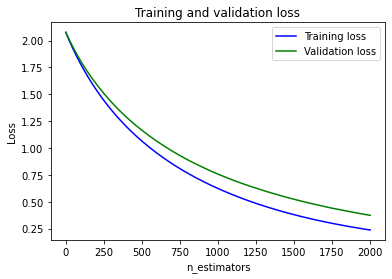

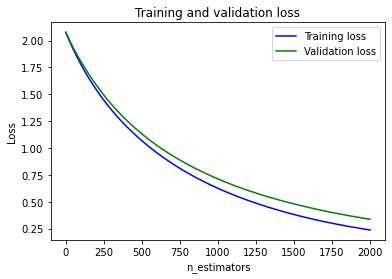

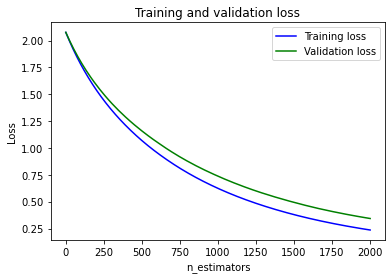

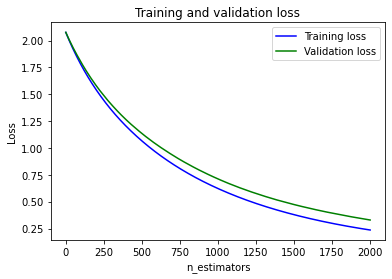

In [31]:
for i in range(4):
    loss = all_history[i].get('validation_0')['mlogloss'] # train
    val_loss = all_history[i].get('validation_1')['mlogloss'] # val
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'b', label='Training loss')  # ‘b’는 파란색 실선을 의미합니다.
    plt.plot(epochs, val_loss, 'g', label='Validation loss') # ‘g’는 초록색 실선을 의미합니다.
    plt.title('Training and validation loss')
    plt.xlabel('n_estimators')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [32]:
preds = model.predict(X_test_2dim)

# Result

In [33]:
# rmse
rmse = np.sqrt(mean_squared_error(y_test, preds)) 
print("RMSE: %f" % (rmse))

RMSE: 0.684653


In [34]:
print(y_test.shape, preds.shape)

(160,) (160,)


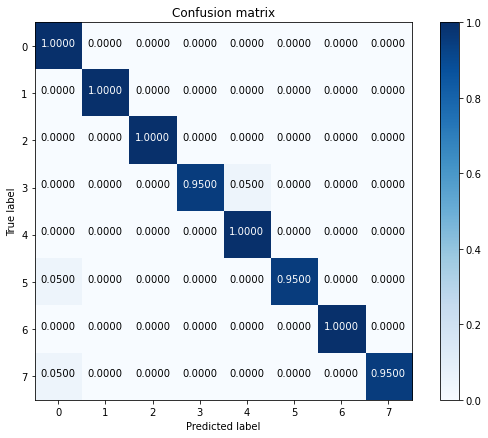

In [35]:
# Confusion Matrix
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, preds)
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    
plot_confusion_matrix(cm,[0,1,2,3,4,5,6,7])

In [36]:
cm

array([[20,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 20,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 20,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 19,  1,  0,  0,  0],
       [ 0,  0,  0,  0, 20,  0,  0,  0],
       [ 1,  0,  0,  0,  0, 19,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 20,  0],
       [ 1,  0,  0,  0,  0,  0,  0, 19]])

In [37]:
# label마다의 confusion matrix
from sklearn.metrics import multilabel_confusion_matrix
cm_mat = multilabel_confusion_matrix(y_test, preds)
cm_mat
# TP FN
# FP TN

array([[[138,   2],
        [  0,  20]],

       [[140,   0],
        [  0,  20]],

       [[140,   0],
        [  0,  20]],

       [[140,   0],
        [  1,  19]],

       [[139,   1],
        [  0,  20]],

       [[140,   0],
        [  1,  19]],

       [[140,   0],
        [  0,  20]],

       [[140,   0],
        [  1,  19]]])

In [38]:
# 평가지표 계산
def confusion(cm):
    return cm[0][0], cm[0][1], cm[1][0], cm[1][1]

def accuracy(cm):
    TP, FN, FP, TN = confusion(cm)
    return (TP+TN)/(TP+TN+FP+FN)

def precision(cm):
    TP, FN, FP, TN = confusion(cm)
    return TP/(TP+FP)

def recall(cm):
    TP, FN, FP, TN = confusion(cm)
    return TP/(TP+FN)

def F1(cm):
    return 2*precision(cm)*recall(cm)/(precision(cm)+recall(cm))

In [39]:
# Macro Average 평가지표 계산
accuracy_avg = 0
precision_avg = 0
recall_avg = 0
F1_avg = 0

for i in range(len(cm_mat)):
    accuracy_avg += accuracy(cm_mat[i])
    precision_avg += precision(cm_mat[i])
    recall_avg += recall(cm_mat[i])
    F1_avg += F1(cm_mat[i])

accuracy_avg /= len(cm_mat)
precision_avg /= len(cm_mat)
recall_avg /= len(cm_mat)
F1_avg /= len(cm_mat)

print('accuracy: ', accuracy_avg)
print('precision: ', precision_avg)
print('recall: ', recall_avg)
print('F1: ', F1_avg)

accuracy:  0.9953125
precision:  0.9973404255319149
recall:  0.9973214285714286
F1:  0.9973181711776715


## Test

In [40]:
images = glob.glob('./01_finger_test/*.bmp')
len(images)

80

In [41]:
r = re.compile('\d+')

img = [] # 이미지
img_num = [] # 이미지 번호

for fname in images:
    num = r.findall(fname)[1]
    img_num.append(num)
    im = pilimg.open(fname)
    pix = np.array(im)[25:120,25:120]/255. # Normalize
    img.append(pix)

In [ ]:
# 지문 이미지
plt.title('finger print')
plt.imshow(X[1], cmap='gray')

In [ ]:
X = np.array(img)
X = X.astype('float32')
X = X.reshape(X.shape[0],95,95,1)
X_test_2dim = X.reshape(X.shape[0], 9025)

In [ ]:
preds = model.predict(X_test_2dim)
preds_n = np.where(preds==0., 8, preds) # 학습 시 바꿨던 라벨 되돌리기
preds_n

In [ ]:
import pandas as pd
res_df = pd.DataFrame(img_num, columns=['Image'], dtype='int32')
res_df['Answer'] = pd.Series(preds_n, dtype='int32')
res_df.sort_values(by=['Image'], axis=0, inplace=True)
res_df

In [ ]:
res_df['Answer'].value_counts()

In [ ]:
res_df.to_csv('./1871085_지문_2차_depth6_estimator2000.csv', index=False)